L'ensemble de données comprend 1885 enregistrements et 32 ​​colonnes, dont:

**5 colonnes démographiques (Nominal data)**: 
  * Age (Real) is age of participant
  * Gender (Real) is gender of participant
  * Education (Real) is level of education of participant
  * Country (Real) is country of current residence of participant
  * Ethnicity (Real) is ethnicity of participant 

**7 mesures de personnalité:**
  * Nscore (Real) is NEO-FFI-R Neuroticism(is a long-term tendency to experience negative emotions such as nervousness, tension, anxiety and depression;)
  * Escore (Real) is NEO-FFI-R Extraversion(is manifested in outgoing, warm, active, assertive, talkative, cheerful, and in search of stimulation characteristics;)
  * Oscore (Real) is NEO-FFI-R Openness to experience( is a general appreciation for art, unusual ideas, and imaginative, creative, unconventional, and wide interests)
  * Ascore (Real) is NEO-FFI-R Agreeableness(is a dimension of interpersonal relations, characterized by altruism, trust, modesty, kindness, compassion and cooperativeness)
  * Cscore (Real) is NEO-FFI-R Conscientiousness(is a tendency to be organized and dependable, strong-willed, persistent, reliable, and efficient.)
  * **Impulsive** (Real) is impulsiveness measured by BIS-11.
  * **SS** (Real) is sensation seeking measured by ImpSS.
  
  ==> We expected that drug usage is associated with high N, and low A and C(à Analyser)

**18 drogues (Ordinal data)**
  * Alcohol consumption
  * Amphetamines consumption
  * Amyl nitrite consumption
  * Benzodiazepine consumption
  * Caffeine consumption
  * Cannabis consumption
  * Chocolate consumption
  * Cocaine consumption
  * Crack consumption
  * Ecstasy consumption
  * Heroin consumption
  * Ketamine consumption
  * Legal highs consumption
  * Lysergic acid diethylamide consumption
  * Methadone consumption
  * Magic mushrooms consumption
  * Nicotine consumption
  * Fictitious drug Semeron consumption (Semeron is a fictitious drug which was introduced to identify overclaimers.)
  * Volatile substance abuse consumption

**5 fréquence de leur utilisation**
  * CL0 - Never Used
  * CL1 - Used over a Decade Ago
  * CL2 - Used in Last Decade
  * CL3 - Used in Last Year
  * CL4 - Used in Last Month
  * CL5 - Used in Last Week
  * CL6 - Used in Last Day

**Problem which can be solved:**
* Seven class classifications for each drug separately.
* Problem can be transformed to binary classification by union of part of classes into one new class. For example, "Never Used", "Used over a Decade Ago" form class "Non-user" and all other classes form class "User".
* The best binarization of classes for each attribute.
* Evaluation of risk to be drug consumer for each drug.

# Librairies

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin, BaseEstimator, ClusterMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_X_y
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

# Fonctions personnalisées

In [396]:
import importlib
if importlib.util.find_spec("missingno") is None:
  !pip install --user --upgrade missingno
import missingno as msno

def inspect_data(df=None, visualize_missing_value=False, display_form='matrix', figsize=(6,4)):
  """ Fonction pour afficher les informations de données.
  - Paramters:
    df: jeu de données en format DataFrame or Series
    visualize_missing_value: is or not to visualize the missing value, default False
    display_form: visualization chart to use, 'matrix'(defaul), 'bar', 'heatmap'
    figsize: The size of the figure to display
  - Return value: None
  """
  print(">>> Les premiers cinq lignes de donnée: \n", df.head())
  if visualize_missing_value == True:
    print(">>> Visualisation de valeurs manquantes:")
    if display_form == 'matrix':
      msno.matrix(df, figsize=figsize)
    if display_form == 'bar':
      msno.bar(df, figsize=figsize)
    if display_form == 'heatmap':
      msno.heatmap(df, figsize=figsize)
  plt.show()
  return

def valueToMeaning(df, attribut, meaning): 
    ''' Convertit une liste de valeur d'un attribut à sa définition.
    df : jeu de données en format DataFrame or Series
    attribut : colonne du jeu de données
    meaning : liste de définition
    '''
    nb_ligne = df.shape[0]
    # Range les valeurs uniques de l'attribut dans l'ordre croissant
    sorted_unique_values = df[attribut].unique()
    sorted_unique_values.sort()

    for i in range(len(meaning)):
        df[attribut].replace({sorted_unique_values[i] : meaning[i]}, inplace=True)

    # Vérifier si on a bien le bon nombre de valeurs pour chaque colonne changée par le nombre d'attributs pour chaque colonne
    if df[attribut].value_counts().sum() == nb_ligne:
      print("==================Bien transformé pour [{0}]=========".format(attribut))

def value_counts_percentage(df, attribut):
    ''' Fonction pour calculer le nombre et le pourcentage des valeurs différentes d'un attribut 
    df: jeu de données en format DataFrame or Series
    attribut : colonne du jeu de données
    '''
    nb_val = df[attribut].value_counts()
    perc_val = df[attribut].value_counts(normalize=True) * 100
    return pd.concat([nb_val,perc_val.round(2)], axis=1, keys=['N', '%'])

def heatmap_corr(df, method='spearman', already=False, mask=True, nominal=False, title=None, figsize=(20,9)):
    ''' Fonction pour visualiser la corrélation
    df - peut être des données «pures» (sans corrélations calculées) ou un DataFrame avec des corrélations déjà calculées (dans ce cas, l'attribut «already» doit être défini sur True)
    method - 'Pearson'(linéaire) ou 'Spearman'(non-linéaire)
    mask - pour cacher les valeurs en triangulaire supérieur et manquantes
    nominal - pour les corrélations de données nominales, les valeurs sont dans la plage (0, 1) au lieu de (-1, -1) et nominal = True doit être suivi par already = True
    '''
    if not already:
        corr = df.corr(method=method)
    elif already:
        corr = df
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    vmax = corr.max().max()
    if nominal:
        center = 0.5
        cmap=None
    elif not nominal:
        center = 0
    if mask:
       mask = np.zeros_like(corr, dtype=np.bool)
       mask[np.triu_indices_from(mask)] = True
       vmax = corr.replace(1, -2).max().max()
    elif not mask:
      mask=None
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, cmap=cmap, mask=mask, vmax=vmax, center=center, annot=True, linewidths=.5, cbar_kws={'shrink': 0.5})
    if title:
      plt.title(title)
    plt.show()

def calculate_corr(df1, df2, method='spearman', p=0.05, pvalues=True):
    ''' Fonction pour calculer la corrélation
    df1, df2 - jeu de données en format DataFrame or Series à utiliser pour calculer la corrélation
    method - 'Pearson'(linéaire) ou 'Spearman'(non-linéaire)
    p - nivea de signification
    pvalues - si défini sur False, seules les valeurs de corrélation seront renvoyées dans DataFrame (sans les marques «**» pour les observations significatives)
    '''
    data_corr_table = pd.DataFrame()
    data_pvalues = pd.DataFrame()
    for x in df1.columns:
        for y in df2.columns:
          if method == 'pearson':
            corr = pearsonr(df1[x], df2[y])
          elif method == 'spearman':
            corr = spearmanr(df1[x], df2[y])
          else:
              raise ValueError('Unknown method')
          if pvalues:
              data_corr_table.loc[x,y] = '{} {}'.format(round(corr[0], 3), '**' if round(corr[1], 3) < p else '')
          elif not pvalues:
              data_corr_table.loc[x,y] = round(corr[0], 3)
          data_pvalues.loc[x,y] = round(corr[1], 3)
    return data_corr_table, data_pvalues

def kmeans_dataset(dataset, n_clusters_list, strategies, tries):
  ''' Fonction pour apppliquer l'algorithme Kmeans pour choisir le meilleur nombre de clustering
    dataset - jeu de données en format DataFrame
    n_clusters_list - liste de nombre de groupes à choisir dans la classification
    strategies - liste de strategies d'initialisation des centres ['k-means++', 'random']
    tries: initialisation de générateur de nombre aléatoire pour que la classification soit reproductible
    '''
  for n_clusters in n_clusters_list:
    for strategy in strategies:  
      for rs in range(tries): # On utilisera `rs` pour fixer le `random_state`
        inertia = (KMeans(n_clusters=n_clusters, init=strategy, n_init=1, random_state=rs).fit(dataset).inertia_)
        yield rs, strategy, n_clusters, inertia

def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """
    Utilise `sns.scatterplot` en appliquant d'abord une ACP si besoin
    pour réduire la dimension.
    """

    # Select columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    sp_kwargs = {}
    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        sp_kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        sp_kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **sp_kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.
    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca

class NearestPrototypes(TransformerMixin, ClusterMixin, BaseEstimator):
    def __init__(self, n_prototypes_list=[3, 3], n_neighbors=5):
        # Définir une assertion pour contrôler que `n_prototypes_list`
        # et `n_neighbors` ont des valeurs cohérentes.
        assert(sum(n_prototypes_list) >= n_neighbors)

        self.n_prototypes_list = n_prototypes_list
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Validation des entrées
        X, y = check_X_y(X, y)

        labels = np.unique(y)
        self.classes_ = labels
        assert(len(labels) == len(self.n_prototypes_list))
        assert(len(y) >= sum(self.n_prototypes_list))

        def prototypes(X, label, n_prototypes):
            """Sélectionne les individus d'étiquette `label` dans `X` et lance un
            algorithme des k-means pour calculer `n_prototypes`
            prototypes.
            """

            # Sélection du jeu de données d'étiquette `label`
            Xk = X[y == label, :]

            # Création d'un objet de classe `KMeans` avec le bon nombre
            # de prototypes
            cls = KMeans(n_clusters=n_prototypes)

            # Apprentissage des prototypes
            cls.fit(Xk)

            return cls.cluster_centers_

        # Concaténation de tous les prototypes pour toutes les
        # étiquettes et le nombre de prototypes correspondants.
        # Utiliser la fonction `prototypes` définies précédemment et
        # la fonction `np.concatenate`.
        self.prototypes_ = np.concatenate([
            prototypes(X, label, n_prototypes)
            for n_prototypes, label in zip(self.n_prototypes_list, labels)
        ])


        # Création des étiquettes pour tous les prototypes construits
        # précédemment. On pourra utiliser `np.repeat`.
        self.labels_ = np.repeat(labels, self.n_prototypes_list)


        # Création d'un objet KNeighborsClassifier
        self.nearest_prototypes_ = KNeighborsClassifier(n_neighbors=self.n_neighbors)


        # Apprentissage du Knn sur les prototypes et leur étiquette
        self.nearest_prototypes_.fit(self.prototypes_, self.labels_)

    def predict(self, X):
        # Prédire les étiquettes en utilisant self.nearest_prototypes_
        return self.nearest_prototypes_.predict(X)

def add_decision_boundary(model, levels=None, resolution=100, ax=None, label=None, color=None, region=True):
    """Trace une frontière et des régions de décision sur une figure existante.

    La fonction requiert un modèle scikit-learn `model` pour prédire
    un score ou une classe. La discrétisation utilisée est fixée par
    l'argument `resolution`. Une (ou plusieurs frontières) sont
    ensuite tracées d'après le paramètre `levels` qui fixe la valeur
    des lignes de niveaux recherchées.

    """

    if ax is None:
        ax = plt.gca()

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.predict(xy).reshape(XX.shape)

    cat2num = {cat: num for num, cat in enumerate(model.classes_)}
    num2cat = {num: cat for num, cat in enumerate(model.classes_)}
    vcat2num = np.vectorize(lambda x: cat2num[x])
    Z_num = vcat2num(Z)

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    mask = np.zeros_like(Z_num, dtype=bool)
    for k in range(len(model.classes_) - 1):
        mask |= Z_num == k - 1
        Z_num_mask = np.ma.array(Z_num, mask=mask)
        ax.contour(
            XX,
            YY,
            Z_num_mask,
            levels=[k + 0.5],
            linestyles="dashed",
            corner_mask=True,
            colors=["red"],
            antialiased=True,
        )

    if region:
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model.classes_]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model.classes_:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model.classes_))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
f1_score, precision_score, recall_score,  precision_recall_curve, roc_curve, plot_roc_curve, auc, roc_auc_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


def split_train_evaluation_plot(X, y, verbose=True, plot_cm=True, title=None):
  # Séparation de données
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  list_accuracy, list_precision, list_sensitivity, list_f1_score = [], [], [], []

  # Entraînement et évaluation
  # Define the model
  cls_lr = LogisticRegression(max_iter=10000, class_weight="balanced")
  # fit on the training set
  cls_lr.fit(X_train, y_train)

  # Predict on test set
  y_pred_lr = cls_lr.predict(X_test)

  Accuracy = cross_val_score(estimator = LogisticRegression(max_iter=10000, class_weight="balanced"), X = X, y = y, cv = 10)

  list_accuracy.append(round(Accuracy.mean()*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_lr)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_lr)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_lr)*100, 2))

  if verbose:
    print("=======================================================LogisticRegression=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_lr)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_lr)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_lr)*100))
    
  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_lr, labels=cls_lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_lr.classes_)
    disp.plot()
    plt.show()

  from sklearn.model_selection import GridSearchCV
  from sklearn.neighbors import KNeighborsClassifier

  # De 1 à 500 voisins (exclu), échelle logarithmique
  n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
  param_grid = {"n_neighbors": n_neighbors_list}

  # GridS earch
  search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
  search.fit(X_train, y_train)
  # print(search.best_params_['n_neighbors'])

  cls_knn = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
  cls_knn.fit(X_train, y_train)

  # predict on test set
  y_pred_knn = cls_knn.predict(X_test)
  
  Accuracy = accuracy_score(y_test, y_pred_knn)
  
  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_knn)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_knn)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_knn)*100, 2))

  if verbose:
    print("=======================================================KNN=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_knn)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_knn)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_knn)*100))

  if plot_cm:
      # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_knn, labels=cls_knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_knn.classes_)
    disp.plot()

  cls_dt = DecisionTreeClassifier(criterion="gini", random_state=42)
  cls_dt.fit(X_train, y_train)

  y_pred_dt = cls_dt.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_dt)
  
  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_dt)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_dt)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_dt)*100, 2))

  if verbose:
    print("=======================================================DecisionTree=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_dt)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_dt)*100))

    # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_dt)*100))

  if plot_cm:
      # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_dt, labels=cls_dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_dt.classes_)
    disp.plot()
    plt.show()

  #Create the SVM model
  cls_svm = SVC(kernel = 'rbf', random_state=42)

  #Fit the model for the data
  cls_svm.fit(X_train, y_train)

  #Make the prediction
  y_pred_svm = cls_svm.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_svm)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_svm)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_svm)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_svm)*100, 2))

  if verbose:
    print("=======================================================SVM=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_svm)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_svm)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_svm)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_svm, labels=cls_svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_svm.classes_)
    disp.plot()
    plt.show()

  cls_GaussianNB = GaussianNB()
  cls_GaussianNB.fit(X_train, y_train)

  y_pred_GaussianNB = cls_GaussianNB.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_GaussianNB)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_GaussianNB)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_GaussianNB)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_GaussianNB)*100, 2))

  if verbose:
    print("=======================================================Naive Bayes=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_GaussianNB)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_GaussianNB)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_GaussianNB)*100))
    
  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_GaussianNB, labels=cls_GaussianNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_GaussianNB.classes_)
    disp.plot()
    plt.show()

  # Linear Discriminant Analysis
  cls_LDA = LinearDiscriminantAnalysis()
  cls_LDA.fit(X_train, y_train)

  y_pred_LDA = cls_LDA.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_LDA)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_LDA)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_LDA)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_LDA)*100, 2))

  if verbose:
    print("=======================================================LDA=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_LDA)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_LDA)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_LDA)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_LDA , labels=cls_LDA.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_LDA.classes_)
    disp.plot()
    plt.show()

  # Quadratic Discriminant Analysis
  cls_QDA = QuadraticDiscriminantAnalysis()
  cls_QDA.fit(X_train, y_train)

  y_pred_QDA = cls_QDA.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_QDA)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_QDA)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_QDA)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_QDA)*100, 2))

  if verbose:
    print("=======================================================QDA=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_QDA)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_QDA)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_QDA)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_QDA, labels=cls_QDA.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_QDA.classes_)
    disp.plot()
    plt.show()

  cls_RF = RandomForestClassifier(max_depth=2, random_state=0)
  cls_RF.fit(X_train, y_train)

  y_pred_RF = cls_RF.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_RF)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_RF)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_RF)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_RF)*100, 2))

  if verbose:
    print("=======================================================Random Forest=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_RF)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_RF)*100))

    # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_RF)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_RF, labels=cls_RF.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_RF.classes_)
    disp.plot()
    plt.show()

  # Affchier courbe ROC et AUC
  fig, ax = plt.subplots(figsize=(6,6))

  # Courbe ROC - LogisticRegression
  plot_roc_curve(cls_lr, X_test, y_test, ax=ax)

  # Courbe ROC - KNN
  plot_roc_curve(cls_knn, X_test, y_test, ax=ax)

  # Courbe ROC - DecisionTree
  plot_roc_curve(cls_dt, X_test, y_test, ax=ax)

  # Courbe ROC - SVM
  plot_roc_curve(cls_svm, X_test, y_test, ax=ax)

  # Courbe ROC - Naive Bayes
  plot_roc_curve(cls_GaussianNB , X_test, y_test, ax=ax)

  # Courbe ROC - LDA
  plot_roc_curve(cls_LDA, X_test, y_test, ax=ax)

  # Courbe ROC - QDA
  plot_roc_curve(cls_QDA, X_test, y_test, ax=ax)

  # Courbe ROC - Random Forest
  plot_roc_curve(cls_RF, X_test, y_test, ax=ax)

  # Courbe ROC - Random Guess
  random_probs = [0 for _ in range(len(y_test))]
  random_auc = roc_auc_score(y_test, random_probs)
  random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
  plt.plot(random_fpr, random_tpr, linestyle='--', label='Random Guess')

  plt.legend()
  plt.title(title)
  plt.show()

  score = {'Accuracy (%)': list_accuracy, 'Precision (%)': list_precision, 'Sensitivity (%)': list_sensitivity, 'F1 Socre (%)': list_f1_score}
  df_score = pd.DataFrame.from_dict(score)
  df_score.index = ['LogisticRegression', 'KNN', 'DecisionTree', 'SVM', 'Naive Bayes', 'LDA', 'QDA', 'Random Forest']

  return df_score

from sklearn.linear_model import LogisticRegression
class LR(LogisticRegression):
  def __init__(self, threshold=0.01, dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1):
    self.threshold = threshold
    LogisticRegression.__init__(self, penalty='l1', dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs)
    self.l2 = LogisticRegression(penalty='l2', dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight = class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs)

  def fit(self, X, y, sample_weight=None):
    super(LR, self).fit(X, y, sample_weight=sample_weight)
    self.coef_old_ = self.coef_.copy()
    self.l2.fit(X, y, sample_weight=sample_weight)

    selected_column_list = []

    cntOfRow, cntOfCol = self.coef_.shape
    for i in range(cntOfRow):
      for j in range(cntOfCol):
        coef = self.coef_[i][j]
        if coef != 0:
          idx = [j]
          coef1 = self.l2.coef_[i][j]
          for k in range(cntOfCol):
            coef2 = self.l2.coef_[i][k]
            if abs(coef1-coef2) < self.threshold and j != k and self.coef_[i][k] == 0:
              idx.append(k)
          mean = coef / len(idx)
          self.coef_[i][idx] = mean

    for i, item in enumerate(self.coef_[0]):
      if item != 0:
        selected_column_list.append(X.columns[i])

    print("Importante features selected: ", selected_column_list)

    return self 

import plotly.express as px
def plot_pca(cls, pca, y, type="2D"):
  if type=="2d" or type=="2D":
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(cls.explained_variance_ratio_ * 100)
    }
    fig = px.scatter_matrix(pca, labels=labels, dimensions=range(3), color=y)
    fig.update_traces(diagonal_visible=False)
  if type=="3d" or type=="3D":
    total_var = cls.explained_variance_ratio_.sum() * 100
    fig = px.scatter_3d(pca, x=0, y=1, z=2, color=y,
        title=f'Total Explained Variance: {total_var:.2f}%',
        labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'}
    )
  fig.show()


import numpy as np
import numpy.linalg as linalg
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array
class AdaptiveKMeans(ClusterMixin, BaseEstimator):
    def __init__(self, n_clusters=8, n_init=10, tol=1e-4, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, X):
        X = check_array(X)

        n, p = X.shape
        n_init = self.n_init
        n_clusters = self.n_clusters
        max_iter = self.max_iter
        tol = self.tol

        centers_opt = None
        Vt_opt = None
        partition_opt = None
        d_opt = float("inf")

        for i in range(n_init):
            # Initialisation des centres des classes avec
            # `np.random.choice`
            centers = np.random.choice(n, size=n_clusters, replace=False)
            centers = X[centers, :]

            # Initialisation des matrices de variance--covariance
            # brutes et normalisées
            Vt = [np.eye(p) for i in range(n_clusters)]
            Vt_norm = [np.eye(p) for i in range(n_clusters)]

            step = tol + 1
            it = 0

            while step > tol and it < max_iter:
                old_centers = centers

                # Calcul d'une nouvelle partition
                dist = np.concatenate(
                    [
                        cdist(c[None, :], X, metric="mahalanobis", VI=linalg.inv(V))
                        for c, V in zip(centers, Vt_norm)
                    ]
                )
                partition = np.argmin(dist, axis=0)

                # Mise à jour des paramètres
                for k in range(n_clusters):
                    # Extraction des individus de class k
                    Xk = X[partition == k, :]

                    # On évite les groupements dégénérés (trop peu de
                    # points pour inverser la matrice de
                    # variance--covariance empirique)
                    if Xk.shape[0] >= p:
                        # Calcul du k-ième centre
                        centers[k, :] = np.mean(Xk, axis=0)

                        # Calcul de la k-ième matrice de
                        # variance-covariance normalisée avec `np.cov` et
                        # `linalg.det`
                        c = np.cov(Xk, bias=True, rowvar=False)
                        c += 1e-5 * np.eye(c.shape[0])

                        Vt[k] = c
                        Vt_norm[k] = (linalg.det(c)) ** (-1 / p) * c

                step = ((old_centers - centers) ** 2).sum()
                it += 1

            # Calcul de `d_tot`. On pourra s'inspirer des instructions
            # permettant de calculer `dist` (voir plus haut).
            d_tot = sum(
                (
                    cdist(
                        c[None, :],
                        X[partition == k, :],
                        metric="mahalanobis",
                        VI=linalg.inv(V),
                    )
                    ** 2
                ).sum()
                for k, (c, V) in enumerate(zip(centers, Vt_norm))
            )

            # Mise à jour du modèle optimal si besoin
            if d_tot < d_opt:
                centers_opt = centers
                Vt_opt = Vt
                Vt_norm_opt = Vt_norm
                partition_opt = partition
                d_opt = d_tot

        self.labels_ = partition_opt
        self.cluster_centers_ = centers_opt
        self.covars_ = Vt_opt
        self.covars_norm_ = Vt_norm_opt
        self.d_opt = d_opt

数据预处理

1. 看定量变量是否符合正太分布，如果不符合，则将其进行标准化(之后在PCA中不在需要处理)
2. 二值化
3. 哑编码

特征选择：基于与目标的相关性，相关性越高，越优先选择

1. Filter: 相关性分析 - 相关系数
2. Embedded: 先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征（使用feature_selection库）

降维: 特征选择后，使用PCA(让映射后的样本具有最大的发散性)或LDA(让映射后的样本有最好的分类性能)/MCA（用于多维定性变量）

聚类分析与描述

同时使用定性和定量数据：将定量数据聚类后，应用FAMD(与MCA相比不会丢失信息)

样本不均衡问题：
  - 使用集成学习，ROC曲线评估
  - 上采样/下采样(只在训练集上，先划分？)



# Téléchargement de données

Mounted at /content/drive
>>> Les premiers cinq lignes de donnée: 
         Age   Gender  Education  Country  ...  Mushrooms  Nicotine  Semer  VSA
ID                                        ...                                 
0   0.49788  0.48246   -0.05921  0.96082  ...        CL0       CL2    CL0  CL0
1  -0.07854 -0.48246    1.98437  0.96082  ...        CL0       CL4    CL0  CL0
2   0.49788 -0.48246   -0.05921  0.96082  ...        CL1       CL0    CL0  CL0
3  -0.95197  0.48246    1.16365  0.96082  ...        CL0       CL2    CL0  CL0
4   0.49788  0.48246    1.98437  0.96082  ...        CL2       CL2    CL0  CL0

[5 rows x 31 columns]
>>> Visualisation de valeurs manquantes:


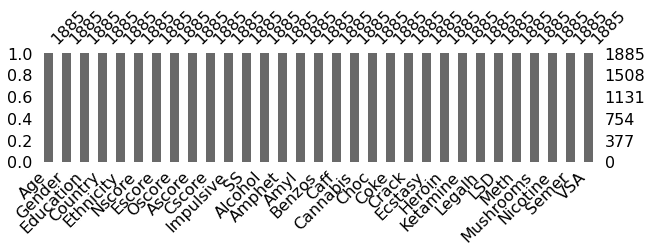

In [397]:
# Monter sur google drive
'''Monter sur Google Drive sur Google Colab afin de pouvoir importer les données à partir des fichiers sur Google Drive'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Remplacer le répertoire de travail par le chemin où on place tous les fichiers de données (.data)
import os
path = "/content/drive/MyDrive/Projet_SY09/data"
os.chdir(path)

# Télécharger les données
colnames = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet', 
            'Amyl', 'Benzos', 'Caff', 'Cannabis','Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh','LSD','Meth','Mushrooms','Nicotine','Semer','VSA']  
df_drug = pd.read_csv("drug_consumption.data", index_col=0, names=colnames).reset_index().drop(columns=['ID'], axis=1)
df_drug.index.set_names('ID', inplace=True)

# Inspecter les données
inspect_data(df_drug, visualize_missing_value=True, display_form='bar', figsize=(10, 2))

On peut constater qu’il n’y a pas de valeur manquante dans
ce jeu de données.

# Statistiques descriptives

## Aperçu géographiques

In [398]:
value_counts_percentage(df_drug, 'Age')

N      %
-0.95197  643  34.11
-0.07854  481  25.52
 0.49788  356  18.89
 1.09449  294  15.60
 1.82213   93   4.93
 2.59171   18   0.95

**==> Conclusion**
  + 18-24 ans est le plus grand groupe d'âge (environ 1/3 de tous les participants.

  + 25-34, c'est 1/4 des participants.

  + 35-54 est un autre 1/3 des participants. Les 5% restants sont des personnes de plus de 55 ans.

In [399]:
value_counts_percentage(df_drug, 'Gender')

N      %
-0.48246  943  50.03
 0.48246  942  49.97

**==> Conclusion**

  Il y a à peu près le même nombre d'hommes et de femmes.

In [400]:
value_counts_percentage(df_drug, 'Education')

N      %
-0.61113  506  26.84
 0.45468  480  25.46
 1.16365  283  15.01
-0.05921  270  14.32
-1.22751  100   5.31
-1.73790   99   5.25
 1.98437   89   4.72
-1.43719   30   1.59
-2.43591   28   1.49

**==> Conclusion**

Les personnes bien éduquées prédominent (avec le niveau universitaire et supérieur) environ 85% de tous. D'autres personnes ont terminé leurs études jusqu'à 18 ans.

In [401]:
value_counts_percentage(df_drug, 'Country')

N      %
 0.96082  1044  55.38
-0.57009   557  29.55
-0.28519   118   6.26
 0.24923    87   4.62
-0.09765    54   2.86
 0.21128    20   1.06
-0.46841     5   0.27

**==> Conclusion**

Tous les pays sont officiellement anglophones et plus de 50% des participants viennent du Royaume-Uni, près d'un tiers des États-Unis.

In [402]:
value_counts_percentage(df_drug, 'Ethnicity')

N      %
-0.31685  1720  91.25
 0.11440    63   3.34
-1.10702    33   1.75
-0.50212    26   1.38
-0.22166    20   1.06
 0.12600    20   1.06
 1.90725     3   0.16

**==> Conclusion**

Plus de 90% des participants sont des Blancs.

In [403]:
pd.crosstab(index=df_drug['Age'], columns=[df_drug['Gender'], df_drug['Country']])

Gender   -0.48246                    ...  0.48246                  
Country  -0.57009 -0.46841 -0.28519  ...  0.21128  0.24923  0.96082
Age                                  ...                           
-0.95197      223        2       39  ...        3        7      112
-0.07854       63        2       26  ...        2        9      200
 0.49788       26        0       10  ...        3        8      150
 1.09449       22        0        5  ...        1        7      127
 1.82213       10        0        2  ...        0        7       29
 2.59171        2        0        0  ...        0        3        5

[6 rows x 14 columns]

**==> Conclusion (Age – Gender – Country cross table)**
  + Aucune personne de plus de 35 ans ont été testés en Nouvelle-Zélande.
  + Aucune personne de plus de 55 ans ont été testés en Irlande.
  + Aucune personne de plus de 65 ans ont été testés en Australie.

In [404]:
pd.crosstab(index=df_drug['Education'], columns=[df_drug['Gender'], df_drug['Ethnicity']])

Gender    -0.48246                    ...  0.48246                  
Ethnicity -1.10702 -0.50212 -0.31685  ...  0.11440  0.12600  1.90725
Education                             ...                           
-2.43591         0        0       16  ...        0        0        0
-1.73790         0        0       54  ...        2        0        0
-1.43719         0        0       14  ...        0        0        0
-1.22751         1        0       56  ...        2        0        0
-0.61113         4        1      310  ...        9        2        1
-0.05921         5        1      120  ...        2        1        0
 0.45468         5        3      171  ...        8        4        1
 1.16365         1        5       93  ...        5        3        0
 1.98437         0        1       29  ...        1        1        0

[9 rows x 14 columns]

**==> Conclusion (Education – Gender – Ethnicity cross table)**
  + Pas trop informations supplémentaires ont été perçues 

## Aperçu mesures de personnalité

In [405]:
df_drug.iloc[:, 5:12].describe()

Nscore       Escore  ...    Impulsive           SS
count  1885.000000  1885.000000  ...  1885.000000  1885.000000
mean      0.000047    -0.000163  ...     0.007216    -0.003292
std       0.998106     0.997448  ...     0.954435     0.963701
min      -3.464360    -3.273930  ...    -2.555240    -2.078480
25%      -0.678250    -0.695090  ...    -0.711260    -0.525930
50%       0.042570     0.003320  ...    -0.217120     0.079870
75%       0.629670     0.637790  ...     0.529750     0.765400
max       3.273930     3.273930  ...     2.901610     1.921730

[8 rows x 7 columns]

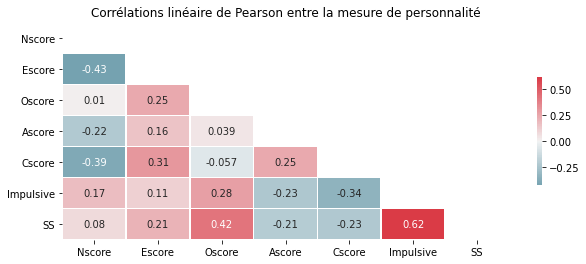

In [406]:
heatmap_corr(df_drug.iloc[:, 5:12], method='pearson', title="Corrélations linéaire de Pearson entre la mesure de personnalité", figsize=(10, 4))

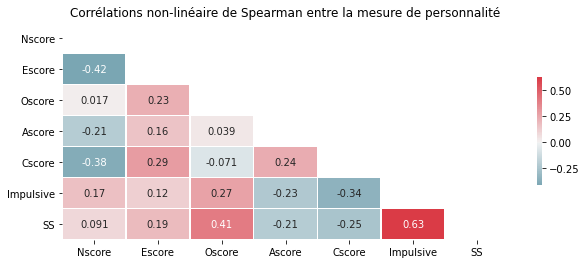

In [407]:
heatmap_corr(df_drug.iloc[:, 5:12], method='spearman', title="Corrélations non-linéaire de Spearman entre la mesure de personnalité", figsize=(10, 4))

**==> Conclusion**

+ Il n'y a pas de corrélation entre Openness to experience et Neuroticism.
+ Les corrélations restantes sont tout au plus des corrélations modérées.
+  Les corrélations (significatives, positives) les plus fortes en ordre décroissantes :
  + Sensation seeking et Impulsiveness (r = 0.63)
  + Sensation seeking et Openness to experience (r = 0.4)
+  Les corrélations (significatives, negatives) les plus fortes en ordre décroissantes :
  + Extraversion and Neuroticism (r = -0.42)
  + Neuroticism and Conscientiousness (r = -0.38)
  + Conscientiousness and Impulsiveness (r = -0.34)

## Aperçu drogues

###  Binarization pour définir les consommateurs et non consommateurs

In [408]:
from collections import Counter

patterns = [
  {'Decade-based': {'CL0':0, 'CL1':0, 'CL2':1, 'CL3':1, 'CL4':1, 'CL5':1, 'CL6':1}},
  {'Year-based': {'CL0':0, 'CL1':0, 'CL2':0, 'CL3':1, 'CL4':1, 'CL5':1, 'CL6':1}},
  {'Month-based': {'CL0':0, 'CL1':0, 'CL2':0, 'CL3':0, 'CL4':1, 'CL5':1, 'CL6':1}},
  {'Week-based': {'CL0':0, 'CL1':0, 'CL2':0, 'CL3':0, 'CL4':0, 'CL5':1, 'CL6':1}}
]

df_final = pd.DataFrame()
for pattern in patterns:
  dic_list = []
  for key, value in pattern.items():
    df_temp = df_drug.replace(to_replace=value)
    for column in df_temp.iloc[:, 12:].columns:
      dic_list.append({column: [Counter(df_temp[column])[0], Counter(df_temp[column])[1], round(Counter(df_temp[column])[1]/(Counter(df_temp[column])[0] + Counter(df_temp[column])[1]),2)* 100]})
  df = pd.DataFrame()
  for item in dic_list:
    df = pd.concat([df, pd.DataFrame(item)], axis=1)
  df.index = ['Non User/'+ key , 'User/' + key, 'User%']
  df_final = pd.concat([df_final, df], axis=0).astype(np.float64)

df_final

Alcohol  Amphet    Amyl  ...  Nicotine   Semer     VSA
Non User/Decade-based     68.0  1206.0  1515.0  ...     621.0  1879.0  1655.0
User/Decade-based       1817.0   679.0   370.0  ...    1264.0     6.0   230.0
User%                     96.0    36.0    20.0  ...      67.0     0.0    12.0
Non User/Year-based      136.0  1449.0  1752.0  ...     825.0  1882.0  1790.0
User/Year-based         1749.0   436.0   133.0  ...    1060.0     3.0    95.0
User%                     93.0    23.0     7.0  ...      56.0     0.0     5.0
Non User/Month-based     334.0  1647.0  1844.0  ...    1010.0  1884.0  1851.0
User/Month-based        1551.0   238.0    41.0  ...     875.0     1.0    34.0
User%                     82.0    13.0     2.0  ...      46.0     0.0     2.0
Non User/Week-based      621.0  1722.0  1868.0  ...    1118.0  1885.0  1864.0
User/Week-based         1264.0   163.0    17.0  ...     767.0     0.0    21.0
User%                     67.0     9.0     1.0  ...      41.0     0.0     1.0

[12 rows x 19 columns]

N'importe quelle définition qu'on va choisir, le nombre de consommateurs et non consommateurs pour toutes les drogues sauf **[Alcohol, Caff, Coke]** sera toujours déséquilibré, surtout pour 'Week-based'.

In [409]:
# Year-based definition
df_drug.replace(to_replace={'CL0':0, 'CL1':0, 'CL2':0, 'CL3':1, 'CL4':1, 'CL5':1, 'CL6':1}, inplace=True)

In [410]:
df_drug.drop(columns=['Semer'], inplace=True)

In [411]:
d1 = df_drug['Alcohol'].value_counts()
d2 = df_drug['Amphet'].value_counts()
d3 = df_drug['Amyl'].value_counts()
d4 = df_drug['Benzos'].value_counts()
d5 = df_drug['Caff'].value_counts()
d6 = df_drug['Cannabis'].value_counts()
d7 = df_drug['Choc'].value_counts()
d8 = df_drug['Coke'].value_counts()
d9 = df_drug['Crack'].value_counts()
d10 = df_drug['Ecstasy'].value_counts()
d11 = df_drug['Heroin'].value_counts()
d12 = df_drug['Ketamine'].value_counts()
d13 = df_drug['Legalh'].value_counts()
d14 = df_drug['LSD'].value_counts()
d15 = df_drug['Meth'].value_counts()
d16 = df_drug['Mushrooms'].value_counts()
d17 = df_drug['Nicotine'].value_counts()
d18 = df_drug['VSA'].value_counts()

drug_table = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18], axis=1, 
      keys=['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA'])
drug_table.T.fillna(0).astype(np.int64)

0     1
Alcohol     136  1749
Amphet     1449   436
Amyl       1752   133
Benzos     1350   535
Caff         61  1824
Cannabis    886   999
Choc         45  1840
Coke       1468   417
Crack      1806    79
Ecstasy    1368   517
Heroin     1767   118
Ketamine   1677   208
Legalh     1321   564
LSD        1505   380
Meth       1565   320
Mushrooms  1451   434
Nicotine    825  1060
VSA        1790    95

**==> Conclusion**

  + L'alcool, la caféine, le chocolat et la nicotine sont des stimulants qui sont consommés assez souvent et presque personne ne les a jamais essayés.
  + Le cannabis se distribue plus uniformément. Il y a presque le même nombre de personnes qui l'ont pris ces derniers temps que le nombre de personnes qui ne l'ont jamais essayé. Intuitions: cela reflète l'attitude de la société vis-à-vis du cannabis en tant que drogue entre drogue «mauvais» et drogue «ordinaire».
  + Pour les restes drogues, la grande majorité des gens ne l'ont jamais essayé, ou l'ont fait il y a longtemps plutôt que récemment (jusqu'à il y a un mois). Intuitions: soit les gens ne le prennent pas du tout (par exemple parce qu'ils en ont peur / ne veulent pas), soit ils l'essayeront une fois et n'y reviendront pas.

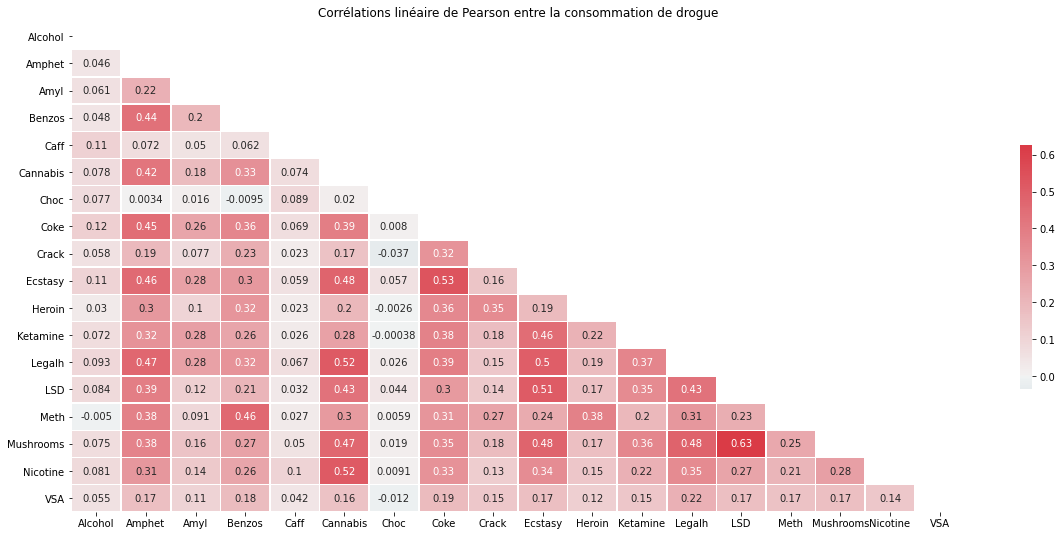

            Alcohol    Amphet      Amyl  ... Mushrooms  Nicotine       VSA
Alcohol      1.0 **  0.046 **  0.061 **  ...  0.075 **  0.081 **  0.055 **
Amphet     0.046 **    1.0 **  0.222 **  ...  0.375 **  0.311 **  0.173 **
Amyl       0.061 **  0.222 **    1.0 **  ...  0.159 **  0.139 **  0.107 **
Benzos     0.048 **  0.436 **  0.199 **  ...  0.271 **  0.261 **  0.183 **
Caff       0.111 **  0.072 **   0.05 **  ...   0.05 **  0.105 **    0.042 
Cannabis   0.078 **  0.421 **  0.185 **  ...   0.47 **  0.517 **  0.164 **
Choc       0.077 **    0.003     0.016   ...    0.019     0.009    -0.012 
Coke       0.124 **  0.453 **  0.262 **  ...  0.346 **  0.328 **  0.187 **
Crack      0.058 **  0.193 **  0.077 **  ...  0.181 **  0.126 **  0.145 **
Ecstasy    0.107 **  0.461 **  0.276 **  ...   0.48 **  0.343 **  0.174 **
Heroin        0.03   0.305 **    0.1 **  ...  0.171 **  0.149 **  0.121 **
Ketamine   0.072 **  0.325 **   0.28 **  ...  0.362 **  0.222 **  0.151 **
Legalh     0.093 **  0.47

In [412]:
heatmap_corr(df_drug.iloc[:, 12:], method='pearson', title="Corrélations linéaire de Pearson entre la consommation de drogue")
df_corr, df_pvalues = calculate_corr(df_drug.iloc[:, 12:], df_drug.iloc[:, 12:])
print(df_corr)

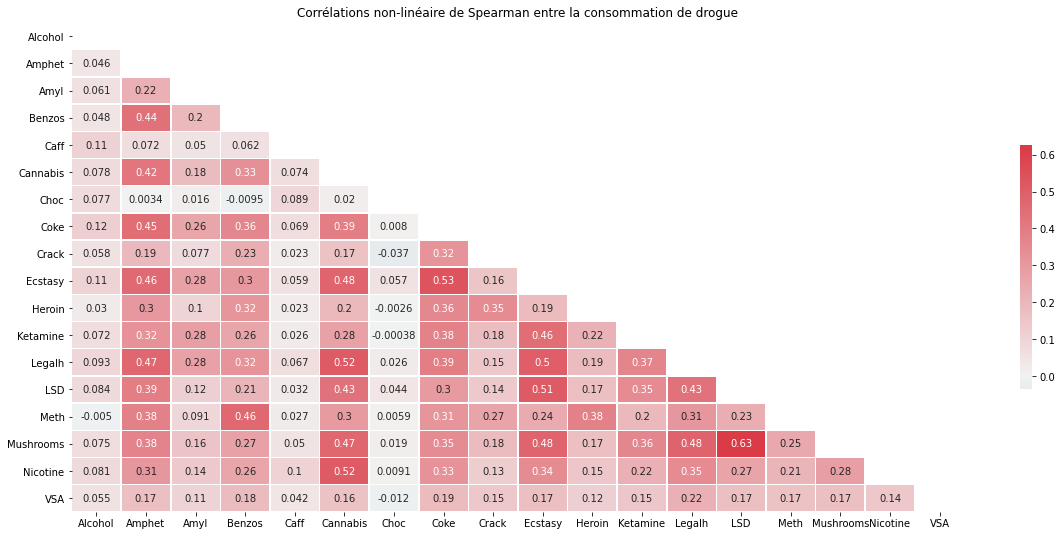

In [413]:
heatmap_corr(df_drug.iloc[:, 12:], method='spearman', title="Corrélations non-linéaire de Spearman entre la consommation de drogue")

**==> Conclusion**

  + Les corrélations non-linéaires entre la consommation de drogue est un peu plus fortes que celles linéaire.
  + L'alcool, la caféine et le chocolat ne sont en aucun cas corrélés aux autres drogues (les corrélations sont faibles ou insignifiantes). - Tout en léger bleu
  + De plus, la consommation d'alcool est légèrement corrélée positivement avec la caféine et l'Amyle, et la caféine est légèrement corrélée positivement avec le chocolat et la nicotine.
  + Le chocolat est faiblement corrélé négativement avec les Mushrooms magiques, le LSD et le Crack.
  + Les corrélations restantes sont au plus des corrélations modérées et il n'y a pas de corrélations fortes entre la prise de stimulants.
  + Les corrélations les plus fortes en ordre décroissante:
    + LSD et Magic mushrooms (cor = 0.67)
    + Ecstasy et Cocaine (cor = 0.63)
    + Cocaine et Amphetamine (cor = 0.61)
    + Magic mushrooms et Cannabis (cor = 0.59)
    + Ecstasy et Amphetamine (cor = 0.58)
    + Legal highs et Cannabis (cor = 0.58)
    + LSD et Ecstasy (cor = 0.58)
    + Ecstasy et Cannabis (cor = 0.57)
    + Magic mushrooms et Ecstasy (cor = 0.57)
    + Legal highs et Ecstasy (cor = 0.57)
    + Magic mushrooms et Afterburners (cor = 0.55)
    + Heroin et Crack (cor = 0.54)
    + LSD et Cannabis (cor = 0.54)
    + Methadone et Benzodiazepines (cor = 0.52)
    + Ketamine et Ecstasy (cor = 0.52)
    + Nicotine et Cannabis (cor = 0.52)
    + LSD et Amphetamine (cor = 0.5)
    + Benzodiazepines et Amphetamines (cor = 0.5)
    + Cannabis et Benzodiazepines (cor = 0.5)
    + Methadone et Heroin (cor = 0.5)

# Prétraitement

## Test de normalité => necessaire pour LDA et QDA

Nscore suit distribution normale


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



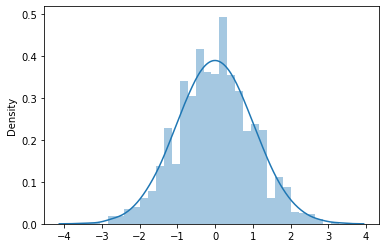

Escore suit distribution normale


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



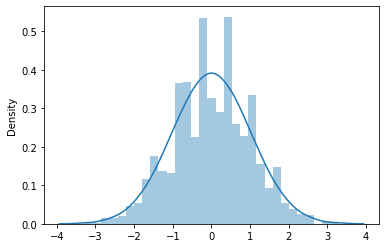

Ascore suit distribution normale


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



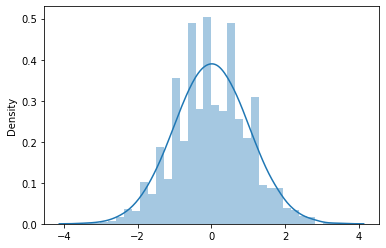

Cscore suit distribution normale


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



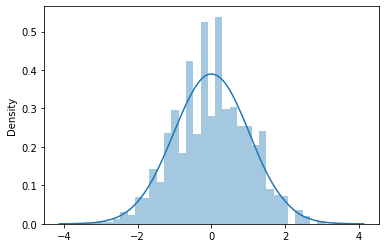

In [414]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

for column in df_drug.iloc[:, :12].columns:
  stat, p = shapiro(df_drug[column])
  if p > 0.01:
    print('{} suit distribution normale'.format(column))
    sns.distplot(x=df_drug[column])
    plt.show()

On constate que tous les **Nscore** suit bien la loi normale au niveau de signifiation 0.05. 

## Standardisation pour les traits de personalité

In [415]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_drug.iloc[:, 5:12] = scaler.fit_transform(df_drug.iloc[:, 5:12])

##  Feature selection

In [416]:
from sklearn.feature_selection import SelectFromModel

# Régression logistique avec les termes de pénalité L1 et L2 comme modèle de base pour sélectinner les caractéristiques
# threshold - le seuil de la différence entre les coefficients de poids de pénalité L1 et L2
def select_features_by_drug(X, y, threshold=0.3, C=0.5):
  return pd.DataFrame(SelectFromModel(LR(threshold=threshold, C=C)).fit_transform(X, y))
  # print(SelectFromModel(LogisticRegression(penalty="l1", C=0.1, solver='liblinear')).fit_transform(X, y))

for column in df_drug.iloc[:, 12:].columns:
  print("=========================={}==========================".format(column))
  select_features_by_drug(df_drug.iloc[:,:5], df_drug[column], threshold=0.01, C=0.02)

==========================Alcohol==========================
Importante features selected:  ['Age']
==========================Amphet==========================
Importante features selected:  ['Age', 'Education', 'Country']
==========================Amyl==========================
Importante features selected:  ['Age']
==========================Benzos==========================
Importante features selected:  ['Age', 'Education', 'Country']
==========================Caff==========================
Importante features selected:  []
==========================Cannabis==========================
Importante features selected:  ['Age', 'Gender', 'Education', 'Country']
==========================Choc==========================
Importante features selected:  []
==========================Coke==========================
Importante features selected:  ['Age', 'Country']
==========================Crack==========================
Importante features selected:  ['Country']
==========================Ecstasy====

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_base.py:81: UserWarning:

No features were selected: either the data is too noisy or the selection test too strict.

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_base.py:81: UserWarning:

No features were selected: either the data is too noisy or the selection test too strict.



Après la séléction de modèle, on voit bien que **[Ethnicity]** a aucune influence sur les drogues, on peut le supprimer pour notre analyse future.

In [417]:
Demo_columns_Amphet = ['Age', 'Education', 'Country']
Demo_columns_Amyl = ['Age']
Demo_columns_Benzos = ['Age', 'Education', 'Country']
Demo_columns_Cannabis = ['Age', 'Gender', 'Education', 'Country']
Demo_columns_Coke = ['Age', 'Country']
Demo_columns_Crack = ['Country']
Demo_columns_Ecstasy = ['Age', 'Gender', 'Country']
Demo_columns_Heroin = ['Country']
Demo_columns_Ketamine = ['Age']
Demo_columns_Legalh = ['Age', 'Gender', 'Education', 'Country']
Demo_columns_LSD = ['Age', 'Country']
Demo_columns_Meth = ['Age', 'Education', 'Country']
Demo_columns_Mushrooms = ['Age', 'Gender', 'Country']
Demo_columns_Nicotine = ['Age', 'Gender', 'Education', 'Country']
Demo_columns_VSA = ['Age', 'Country']

Personality_columns = ['Nscore', 'Oscore', 'Cscore', 'SS'] 

In [418]:
def split_train_evaluation_plot(X, y, verbose=True, plot_cm=True, title=None):
  # Séparation de données
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  list_accuracy, list_precision, list_sensitivity, list_f1_score = [], [], [], []

  # Entraînement et évaluation
  # Define the model
  cls_lr = LogisticRegression(max_iter=10000, class_weight="balanced")
  # fit on the training set
  cls_lr.fit(X_train, y_train)

  # Predict on test set
  y_pred_lr = cls_lr.predict(X_test)

  Accuracy = cross_val_score(estimator = LogisticRegression(max_iter=10000, class_weight="balanced"), X = X, y = y, cv = 10)

  list_accuracy.append(round(Accuracy.mean()*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_lr)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_lr)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_lr)*100, 2))

  if verbose:
    print("=======================================================LogisticRegression=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_lr)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_lr)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_lr)*100))
    
  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_lr, labels=cls_lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_lr.classes_)
    disp.plot()
    plt.show()

  from sklearn.model_selection import GridSearchCV
  from sklearn.neighbors import KNeighborsClassifier

  # De 1 à 500 voisins (exclu), échelle logarithmique
  n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
  param_grid = {"n_neighbors": n_neighbors_list}

  # GridS earch
  search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
  search.fit(X_train, y_train)
  # print(search.best_params_['n_neighbors'])

  cls_knn = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
  cls_knn.fit(X_train, y_train)

  # predict on test set
  y_pred_knn = cls_knn.predict(X_test)
  
  Accuracy = accuracy_score(y_test, y_pred_knn)
  
  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_knn)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_knn)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_knn)*100, 2))

  if verbose:
    print("=======================================================KNN=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_knn)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_knn)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_knn)*100))

  if plot_cm:
      # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_knn, labels=cls_knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_knn.classes_)
    disp.plot()

  cls_dt = DecisionTreeClassifier(criterion="gini", random_state=42)
  cls_dt.fit(X_train, y_train)

  y_pred_dt = cls_dt.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_dt)
  
  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_dt)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_dt)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_dt)*100, 2))

  if verbose:
    print("=======================================================DecisionTree=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_dt)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_dt)*100))

    # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_dt)*100))

  if plot_cm:
      # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_dt, labels=cls_dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_dt.classes_)
    disp.plot()
    plt.show()

  #Create the SVM model
  cls_svm = SVC(kernel = 'rbf', random_state=42)

  #Fit the model for the data
  cls_svm.fit(X_train, y_train)

  #Make the prediction
  y_pred_svm = cls_svm.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_svm)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_svm)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_svm)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_svm)*100, 2))

  if verbose:
    print("=======================================================SVM=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_svm)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_svm)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_svm)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_svm, labels=cls_svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_svm.classes_)
    disp.plot()
    plt.show()

  cls_GaussianNB = GaussianNB()
  cls_GaussianNB.fit(X_train, y_train)

  y_pred_GaussianNB = cls_GaussianNB.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_GaussianNB)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_GaussianNB)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_GaussianNB)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_GaussianNB)*100, 2))

  if verbose:
    print("=======================================================Naive Bayes=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_GaussianNB)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_GaussianNB)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_GaussianNB)*100))
    
  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_GaussianNB, labels=cls_GaussianNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_GaussianNB.classes_)
    disp.plot()
    plt.show()

  # Linear Discriminant Analysis
  cls_LDA = LinearDiscriminantAnalysis()
  cls_LDA.fit(X_train, y_train)

  y_pred_LDA = cls_LDA.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_LDA)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_LDA)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_LDA)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_LDA)*100, 2))

  if verbose:
    print("=======================================================LDA=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_LDA)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_LDA)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_LDA)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_LDA , labels=cls_LDA.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_LDA.classes_)
    disp.plot()
    plt.show()

  # Quadratic Discriminant Analysis
  cls_QDA = QuadraticDiscriminantAnalysis()
  cls_QDA.fit(X_train, y_train)

  y_pred_QDA = cls_QDA.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_QDA)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_QDA)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_QDA)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_QDA)*100, 2))

  if verbose:
    print("=======================================================QDA=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_QDA)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_QDA)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_QDA)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_QDA, labels=cls_QDA.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_QDA.classes_)
    disp.plot()
    plt.show()

  cls_RF = RandomForestClassifier(max_depth=2, random_state=0)
  cls_RF.fit(X_train, y_train)

  y_pred_RF = cls_RF.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_RF)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_RF)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_RF)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_RF)*100, 2))

  if verbose:
    print("=======================================================Random Forest=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_RF)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_RF)*100))

    # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_RF)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_RF, labels=cls_RF.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_RF.classes_)
    disp.plot()
    plt.show()

  # Affchier courbe ROC et AUC
  fig, ax = plt.subplots(figsize=(6,6))

  # Courbe ROC - LogisticRegression
  plot_roc_curve(cls_lr, X_test, y_test, ax=ax)

  # Courbe ROC - KNN
  plot_roc_curve(cls_knn, X_test, y_test, ax=ax)

  # Courbe ROC - DecisionTree
  plot_roc_curve(cls_dt, X_test, y_test, ax=ax)

  # Courbe ROC - SVM
  plot_roc_curve(cls_svm, X_test, y_test, ax=ax)

  # Courbe ROC - Naive Bayes
  plot_roc_curve(cls_GaussianNB , X_test, y_test, ax=ax)

  # Courbe ROC - LDA
  plot_roc_curve(cls_LDA, X_test, y_test, ax=ax)

  # Courbe ROC - QDA
  plot_roc_curve(cls_QDA, X_test, y_test, ax=ax)

  # Courbe ROC - Random Forest
  plot_roc_curve(cls_RF, X_test, y_test, ax=ax)

  # Courbe ROC - Random Guess
  random_probs = [0 for _ in range(len(y_test))]
  random_auc = roc_auc_score(y_test, random_probs)
  random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
  plt.plot(random_fpr, random_tpr, linestyle='--', label='Random Guess')

  plt.legend()
  plt.title(title)
  plt.show()

  score = {'Accuracy (%)': list_accuracy, 'Precision (%)': list_precision, 'Sensitivity (%)': list_sensitivity, 'F1 Socre (%)': list_f1_score}
  df_score = pd.DataFrame.from_dict(score)
  df_score.index = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'Naive Bayes', 'LDA', 'QDA', 'Random Forest']


  print("=======================================================AdaBoost=======================================================")
  clf_AB = AdaBoostClassifier(n_estimators=100, random_state=0)
  clf_AB.fit(X_train, y_train)
  y_pred_AB = clf_AB.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_AB)
  
  # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
  print("Accuracy: {:.2f} %".format(Accuracy*100))

  # Precision = tp / (tp + fp) --> parlant
  print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_AB)*100))

  # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
  print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_AB)*100))

  # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

  # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
  print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_AB)*100))
  

  print("=======================================================Bagging=======================================================")
  clf_B = BaggingClassifier(n_estimators=100, random_state=0)
  clf_B.fit(X_train, y_train)
  y_pred_B = clf_B.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_B)
  
  # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
  print("Accuracy: {:.2f} %".format(Accuracy*100))

  # Precision = tp / (tp + fp) --> parlant
  print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_B)*100))

  # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
  print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_B)*100))

  # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

  # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
  print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_B)*100))

  print("=======================================================Stacking Classifier=======================================================")
  estimators = [
    ('rf', cls_RF),
    ('svc', cls_svm),
    ('knn', cls_knn)
  ]

  clf_SC = StackingClassifier(estimators=estimators, final_estimator=cls_lr, cv=10)

  clf_SC.fit(X_train, y_train)
  y_pred_SC = clf_SC.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_SC)
  
  # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
  print("Accuracy: {:.2f} %".format(Accuracy*100))

  # Precision = tp / (tp + fp) --> parlant
  print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_SC)*100))

  # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
  print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_SC)*100))

  # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

  # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
  print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_SC)*100))

  return df_score


# Amphet

## Transformation

In [419]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Amphet + Personality_columns]
drug = df_drug['Amphet']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Amphet:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Amphet = pd.concat([attributes, drug], axis=1)
df_Amphet.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age             Education Country  ...    Cscore        SS  Amphet
ID                                       ...                            
0   35-44  Professional diploma      UK  ... -0.006281 -1.222226       0
1   25-34      Doctorate degree      UK  ... -0.142775 -0.220519       0
2   35-44  Professional diploma      UK  ... -1.016902  0.420129       0
3   18-24        Masters degree      UK  ...  0.586885 -1.222226       0
4   35-44      Doctorate degree      UK  ...  1.310098 -0.220519       0

[5 rows x 8 columns]

## One-Hot codage

In [420]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Amphet.iloc[:,0:1]
nominal_features = df_Amphet.iloc[:, 1:len(Demo_columns_Amphet)]

X = np.concatenate((Age, nominal_features, df_Amphet.iloc[:,len(Demo_columns_Amphet):-1]), axis=1)
y_Amphet = df_Amphet.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Amphet)])

X_Amphet = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Amphet)]),
    X[:,len(Demo_columns_Amphet):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)


Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [421]:
from sklearn.decomposition import PCA

cls_Amphet = PCA(n_components=4)
pca_Amphet = cls_Amphet.fit_transform(X_Amphet)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Amphet.explained_variance_ratio_, sum(cls_Amphet.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.33549732 0.20607488 0.14965979 0.1017776 ] - total: 0.793009591876834


In [422]:
plot_pca(cls_Amphet, pca_Amphet, y_Amphet, type="2D")

In [423]:
plot_pca(cls_Amphet, pca_Amphet, y_Amphet, type="3D")

## K-means

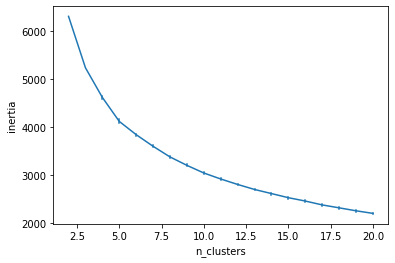

In [424]:
gen = kmeans_dataset(pca_Amphet, range(2, 21), ["random", "k-means++"], 20)
df = pd.DataFrame(gen, columns=["seed", "init", "n_clusters", "inertia"])
sns.lineplot(x="n_clusters", y="inertia", data=df.loc[df.init == "k-means++"], err_style="bars", ci="sd")
plt.show()

D’après la méthode de coude, un bon nombre de groupements est 3 voir 4

ARI score is: 0.003588788752813275


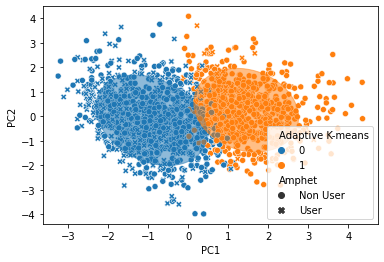

ARI score is: 0.058030249485624505


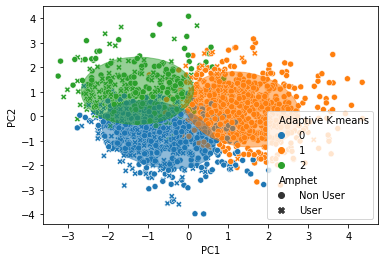

ARI score is: 0.07604848817284766


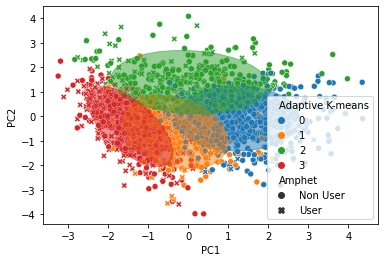

ARI score is: 0.03199475728970165


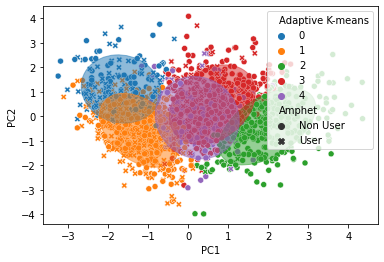

In [425]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

for n_cluster in range(2, 6):
  cls_akm = AdaptiveKMeans(n_clusters=n_cluster)
  labels = cls_akm.fit_predict(pca_Amphet)

  print("ARI score is:", adjusted_rand_score(labels_true=y_Amphet, labels_pred=labels))

  labels = pd.Series(labels, name="Adaptive K-means")
  plot_clustering(pd.DataFrame(pca_Amphet), clus1=labels, clus2=y_Amphet.replace({0:'Non User', 1:'User'}), centers=cls_akm.cluster_centers_, covars=cls_akm.covars_)
  plt.show()

## Resampling





In [426]:
pip install imbalanced-learn

In [427]:
# Resampling
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Amphet, y_rs_Amphet = sampler.fit_sample(pca_Amphet, y_Amphet)
print('Random undersampling {}'.format(Counter(y_rs_Amphet)))

Random undersampling Counter({0: 1449, 1: 1449})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

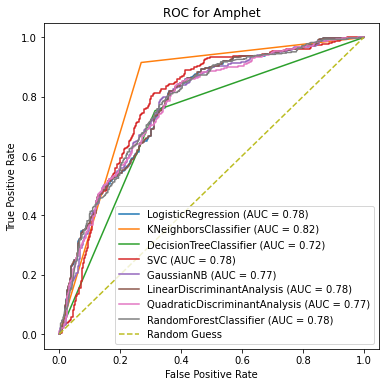

=======================================================AdaBoost=======================================================
Accuracy: 70.01 %
Precision score: 67.09 %
Recall/Sensibilité/sensitivity score: 77.43 %
F1 score: 71.89 %
=======================================================Bagging=======================================================
Accuracy: 80.56 %
Precision score: 76.37 %
Recall/Sensibilité/sensitivity score: 87.97 %
F1 score: 81.76 %
=======================================================Stacking Classifier=======================================================
Accuracy: 81.71 %
Precision score: 77.43 %
Recall/Sensibilité/sensitivity score: 89.03 %
F1 score: 82.83 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         71.22          68.81            69.83         69.32
KNN                         82.24          76.95            91.56         83.62
Decision Tree               71.89          70.14            75.32         72.63
SVM                         73.35          68.91            84.18         75.78
Naive Bayes                 72.52          69.29            79.96         74.24
LDA                         70.95          69.60            73.42         71.46
QDA                         71.26          68.67            77.22         72.69
Random Forest               71.89          67.17            84.60         74.88

In [428]:
split_train_evaluation_plot(X_rs_Amphet, y_rs_Amphet, verbose=False, plot_cm=False, title="ROC for Amphet")

# Amyl

## Transformation

In [429]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Amyl + Personality_columns]
drug = df_drug['Amyl']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Amyl:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Amyl = pd.concat([attributes, drug], axis=1)
df_Amyl.head()

==================Bien transformé pour [Age]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age    Nscore    Oscore    Cscore        SS  Amyl
ID                                                     
0   35-44  0.313500 -0.585137 -0.006281 -1.222226     0
1   25-34 -0.679764  1.441683 -0.142775 -0.220519     0
2   35-44 -0.468308 -0.850217 -1.016902  0.420129     0
3   18-24 -0.149189 -0.018822  0.586885 -1.222226     0
4   35-44  0.736994 -0.453034  1.310098 -0.220519     0

## One-Hot codage

In [430]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Amyl.iloc[:,0:1]
nominal_features = df_Amyl.iloc[:, 1:len(Demo_columns_Amyl)]

X = np.concatenate((Age, nominal_features, df_Amyl.iloc[:,len(Demo_columns_Amyl):-1]), axis=1)
y_Amyl = df_Amyl.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
# onehot_encoder = OneHotEncoder(sparse=False)
# onehot_encoder.fit(X[:, 1:len(Demo_columns_Amyl)])

X_Amyl = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    # onehot_encoder.transform(X[:,1:len(Demo_columns_Amyl)]),
    X[:,len(Demo_columns_Amyl):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
# print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]


## PCA - Dimension Reduction

In [431]:
from sklearn.decomposition import PCA

cls_Amyl = PCA(n_components=4)
pca_Amyl = cls_Amyl.fit_transform(X_Amyl)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Amyl.explained_variance_ratio_, sum(cls_Amyl.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.41025935 0.26768102 0.19121429 0.13084533] - total: 0.9999999999999999


In [432]:
plot_pca(cls_Amyl, pca_Amyl, y_Amyl, type="2D")

In [433]:
plot_pca(cls_Amyl, pca_Amyl, y_Amyl, type="3D")

## Resampling





In [434]:
pip install imbalanced-learn

In [435]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Amyl, y_rs_Amyl = sampler.fit_sample(pca_Amyl, y_Amyl)
print('Random undersampling {}'.format(Counter(y_rs_Amyl)))

Random undersampling Counter({0: 1752, 1: 1752})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

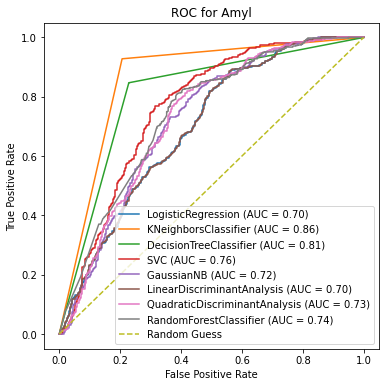

=======================================================AdaBoost=======================================================
Accuracy: 69.14 %
Precision score: 64.78 %
Recall/Sensibilité/sensitivity score: 78.42 %
F1 score: 70.95 %
=======================================================Bagging=======================================================
Accuracy: 84.01 %
Precision score: 79.21 %
Recall/Sensibilité/sensitivity score: 90.47 %
F1 score: 84.47 %
=======================================================Stacking Classifier=======================================================
Accuracy: 85.83 %
Precision score: 80.62 %
Recall/Sensibilité/sensitivity score: 92.81 %
F1 score: 86.29 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         62.77          59.94            67.27         63.39
KNN                         85.83          80.62            92.81         86.29
Decision Tree               80.73          77.43            84.53         80.83
SVM                         70.61          64.44            86.69         73.93
Naive Bayes                 67.68          62.17            83.63         71.32
LDA                         63.09          59.70            71.40         65.03
QDA                         67.76          62.02            84.89         71.68
Random Forest               67.24          61.45            85.43         71.48

In [436]:
split_train_evaluation_plot(X_rs_Amyl, y_rs_Amyl, verbose=False, plot_cm=False, title="ROC for Amyl")

# Benzos

## Transformation

In [437]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Benzos + Personality_columns]
drug = df_drug['Benzos']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Benzos:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Benzos = pd.concat([attributes, drug], axis=1)
df_Benzos.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age             Education Country  ...    Cscore        SS  Benzos
ID                                       ...                            
0   35-44  Professional diploma      UK  ... -0.006281 -1.222226       0
1   25-34      Doctorate degree      UK  ... -0.142775 -0.220519       0
2   35-44  Professional diploma      UK  ... -1.016902  0.420129       0
3   18-24        Masters degree      UK  ...  0.586885 -1.222226       1
4   35-44      Doctorate degree      UK  ...  1.310098 -0.220519       0

[5 rows x 8 columns]

## One-Hot codage

In [438]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Benzos.iloc[:,0:1]
nominal_features = df_Benzos.iloc[:, 1:len(Demo_columns_Benzos)]

X = np.concatenate((Age, nominal_features, df_Benzos.iloc[:,len(Demo_columns_Benzos):-1]), axis=1)
y_Benzos = df_Benzos.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Benzos)])

X_Benzos = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Benzos)]),
    X[:,len(Demo_columns_Benzos):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [439]:
from sklearn.decomposition import PCA

cls_Benzos = PCA(n_components=4)
pca_Benzos = cls_Benzos.fit_transform(X_Benzos)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Benzos.explained_variance_ratio_, sum(cls_Benzos.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.33549732 0.20607488 0.14965979 0.1017776 ] - total: 0.793009591876835


In [440]:
plot_pca(cls_Benzos, pca_Benzos, y_Benzos, type="2D")

In [441]:
plot_pca(cls_Benzos, pca_Benzos, y_Benzos, type="3D")

## Resampling





In [442]:
pip install imbalanced-learn

In [443]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs, y_rs = sampler.fit_sample(pca_Benzos, y_Benzos)
print('Random undersampling {}'.format(Counter(y_rs)))

Random undersampling Counter({0: 1350, 1: 1350})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

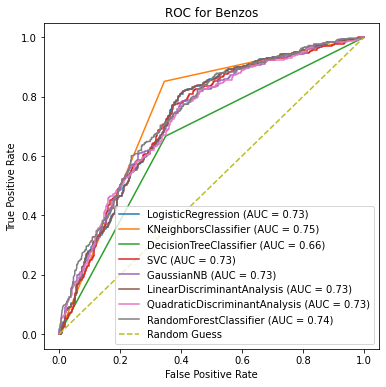

=======================================================AdaBoost=======================================================
Accuracy: 67.68 %
Precision score: 64.77 %
Recall/Sensibilité/sensitivity score: 75.40 %
F1 score: 69.68 %
=======================================================Bagging=======================================================
Accuracy: 76.99 %
Precision score: 73.68 %
Recall/Sensibilité/sensitivity score: 82.92 %
F1 score: 78.03 %
=======================================================Stacking Classifier=======================================================
Accuracy: 74.86 %
Precision score: 71.20 %
Recall/Sensibilité/sensitivity score: 82.23 %
F1 score: 76.32 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         66.81          66.60            71.30         68.87
KNN                         75.20          70.57            85.19         77.19
Decision Tree               65.88          64.97            66.74         65.84
SVM                         68.69          64.81            79.73         71.50
Naive Bayes                 68.57          65.38            76.99         70.71
LDA                         68.13          66.25            71.98         69.00
QDA                         68.13          64.82            77.22         70.48
Random Forest               67.79          64.84            75.63         69.82

In [444]:
split_train_evaluation_plot(X_rs, y_rs, verbose=False, plot_cm=False, title="ROC for Benzos")

# Cannabis

## Transformation

In [445]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Cannabis + Personality_columns]
drug = df_drug['Cannabis']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Cannabis:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Cannabis = pd.concat([attributes, drug], axis=1)
df_Cannabis.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Gender]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age  Gender             Education  ...    Cscore        SS  Cannabis
ID                                       ...                              
0   35-44  Female  Professional diploma  ... -0.006281 -1.222226         0
1   25-34    Male      Doctorate degree  ... -0.142775 -0.220519         1
2   35-44    Male  Professional diploma  ... -1.016902  0.420129         1
3   18-24  Female        Masters degree  ...  0.586885 -1.222226         0
4   35-44  Female      Doctorate degree  ...  1.310098 -0.220519         1

[5 rows x 9 columns]

## One-Hot codage

In [446]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Cannabis.iloc[:,0:1]
nominal_features = df_Cannabis.iloc[:, 1:len(Demo_columns_Cannabis)]

X = np.concatenate((Age, nominal_features, df_Cannabis.iloc[:,len(Demo_columns_Cannabis):-1]), axis=1)
y_Cannabis = df_Cannabis.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Cannabis)])

X_Cannabis = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Cannabis)]),
    X[:,len(Demo_columns_Cannabis):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Female', 'Male'], dtype=object), array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [447]:
from sklearn.decomposition import PCA

cls_Cannabis = PCA(n_components=4)
pca_Cannabis = cls_Cannabis.fit_transform(X_Cannabis)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Cannabis.explained_variance_ratio_, sum(cls_Cannabis.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.31235456 0.19042839 0.14029224 0.10541734] - total: 0.7484925308070246


In [448]:
plot_pca(cls_Cannabis, pca_Cannabis, y_Cannabis, type="2D")

In [449]:
plot_pca(cls_Cannabis, pca_Cannabis, y_Cannabis, type="3D")

## Resampling





In [450]:
pip install imbalanced-learn

In [451]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Cannabis, y_rs_Cannabis = sampler.fit_sample(pca_Cannabis, y_Cannabis)
print('Random undersampling {}'.format(Counter(y_rs_Cannabis)))

Random undersampling Counter({0: 999, 1: 999})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

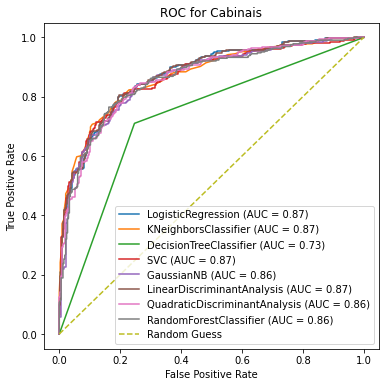

=======================================================AdaBoost=======================================================
Accuracy: 78.48 %
Precision score: 77.84 %
Recall/Sensibilité/sensitivity score: 79.27 %
F1 score: 78.55 %
=======================================================Bagging=======================================================
Accuracy: 79.39 %
Precision score: 79.09 %
Recall/Sensibilité/sensitivity score: 79.57 %
F1 score: 79.33 %
=======================================================Stacking Classifier=======================================================
Accuracy: 79.24 %
Precision score: 79.94 %
Recall/Sensibilité/sensitivity score: 77.74 %
F1 score: 78.83 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         78.53          80.19            78.96         79.57
KNN                         79.55          80.83            77.13         78.94
Decision Tree               73.18          73.97            71.04         72.47
SVM                         79.39          80.19            77.74         78.95
Naive Bayes                 78.18          78.05            78.05         78.05
LDA                         79.85          80.19            78.96         79.57
QDA                         79.09          79.87            77.44         78.64
Random Forest               79.70          80.89            77.44         79.13

In [452]:
split_train_evaluation_plot(X_rs_Cannabis, y_rs_Cannabis, verbose=False, plot_cm=False, title="ROC for Cabinais")

# Coke

## Transformation

In [453]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Coke + Personality_columns]
drug = df_drug['Coke']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Coke:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Coke = pd.concat([attributes, drug], axis=1)
df_Coke.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age Country    Nscore    Oscore    Cscore        SS  Coke
ID                                                             
0   35-44      UK  0.313500 -0.585137 -0.006281 -1.222226     0
1   25-34      UK -0.679764  1.441683 -0.142775 -0.220519     1
2   35-44      UK -0.468308 -0.850217 -1.016902  0.420129     0
3   18-24      UK -0.149189 -0.018822  0.586885 -1.222226     0
4   35-44      UK  0.736994 -0.453034  1.310098 -0.220519     0

## One-Hot codage

In [454]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Coke.iloc[:,0:1]
nominal_features = df_Coke.iloc[:, 1:len(Demo_columns_Coke)]

X = np.concatenate((Age, nominal_features, df_Coke.iloc[:,len(Demo_columns_Coke):-1]), axis=1)
y_Coke = df_Coke.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Coke)])

X_Coke = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Coke)]),
    X[:,len(Demo_columns_Coke):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [455]:
from sklearn.decomposition import PCA

cls_Coke = PCA(n_components=4)
pca_Coke = cls_Coke.fit_transform(X_Coke)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Coke.explained_variance_ratio_, sum(cls_Coke.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.37906414 0.23738151 0.17262194 0.11606396] - total: 0.9051315478203926


In [456]:
plot_pca(cls_Coke, pca_Coke, y_Coke, type="2D")

In [457]:
plot_pca(cls_Coke, pca_Coke, y_Coke, type="3D")

## Resampling





In [458]:
pip install imbalanced-learn

In [459]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Coke, y_rs_Coke = sampler.fit_sample(pca_Coke, y_Coke)
print('Random undersampling {}'.format(Counter(y_rs_Coke)))

Random undersampling Counter({0: 1468, 1: 1468})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

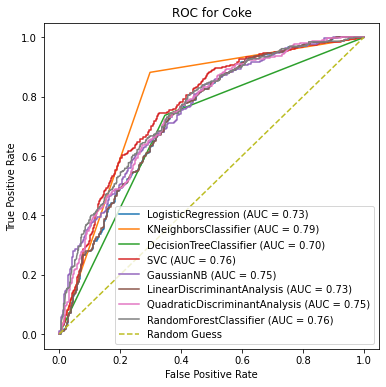

=======================================================AdaBoost=======================================================
Accuracy: 67.39 %
Precision score: 63.84 %
Recall/Sensibilité/sensitivity score: 77.52 %
F1 score: 70.02 %
=======================================================Bagging=======================================================
Accuracy: 75.34 %
Precision score: 71.35 %
Recall/Sensibilité/sensitivity score: 83.19 %
F1 score: 76.82 %
=======================================================Stacking Classifier=======================================================
Accuracy: 79.15 %
Precision score: 74.20 %
Recall/Sensibilité/sensitivity score: 88.24 %
F1 score: 80.61 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         68.97          64.93            75.84         69.96
KNN                         79.05          74.07            88.24         80.54
Decision Tree               69.45          67.24            73.74         70.34
SVM                         68.73          64.30            81.72         71.97
Naive Bayes                 67.80          63.62            80.46         71.06
LDA                         68.01          64.51            77.52         70.42
QDA                         67.49          63.58            79.20         70.53
Random Forest               67.29          62.21            85.08         71.87

In [460]:
split_train_evaluation_plot(X_rs_Coke, y_rs_Coke, verbose=False, plot_cm=False, title="ROC for Coke")

# Crack

## Transformation

In [461]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Crack + Personality_columns]
drug = df_drug['Crack']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Crack:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Crack = pd.concat([attributes, drug], axis=1)
df_Crack.head()

==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Country    Nscore    Oscore    Cscore        SS  Crack
ID                                                       
0       UK  0.313500 -0.585137 -0.006281 -1.222226      0
1       UK -0.679764  1.441683 -0.142775 -0.220519      0
2       UK -0.468308 -0.850217 -1.016902  0.420129      0
3       UK -0.149189 -0.018822  0.586885 -1.222226      0
4       UK  0.736994 -0.453034  1.310098 -0.220519      0

## One-Hot codage

In [462]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Crack.iloc[:,0:1]
nominal_features = df_Crack.iloc[:, 1:len(Demo_columns_Crack)]

X = np.concatenate((Age, nominal_features, df_Crack.iloc[:,len(Demo_columns_Crack):-1]), axis=1)
y_Crack = df_Crack.iloc[:, -1]

# Ordinal encode age
# ordinal_encoder = OrdinalEncoder()
# ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, :len(Demo_columns_Crack)])

X_Crack = np.concatenate(
    (
    # ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,:len(Demo_columns_Crack)]),
    X[:,len(Demo_columns_Crack):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

# print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour les attributs nominaux:  [array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## Resampling





In [463]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Crack, y_rs_Crack = sampler.fit_sample(X_Crack, y_Crack)
print('Random undersampling {}'.format(Counter(y_rs_Crack)))

Random undersampling Counter({0: 1806, 1: 1806})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## PCA - Dimension Reduction

In [464]:
from sklearn.decomposition import PCA

cls_Crack = PCA(n_components=4)
pca_Crack = cls_Crack.fit_transform(X_rs_Crack)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Crack.explained_variance_ratio_, sum(cls_Crack.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.40663594 0.28616288 0.15260154 0.08908766] - total: 0.934488019214806


In [465]:
plot_pca(cls_Crack, pca_Crack, y_rs_Crack, type="2D")

In [466]:
plot_pca(cls_Crack, pca_Crack, y_rs_Crack, type="3D")

## Split & training & Evaluation & Plot

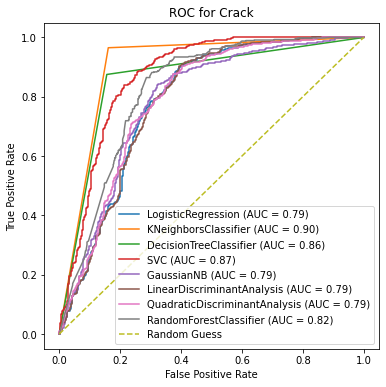

=======================================================AdaBoost=======================================================
Accuracy: 77.18 %
Precision score: 74.88 %
Recall/Sensibilité/sensitivity score: 79.55 %
F1 score: 77.14 %
=======================================================Bagging=======================================================
Accuracy: 89.85 %
Precision score: 85.29 %
Recall/Sensibilité/sensitivity score: 95.49 %
F1 score: 90.11 %
=======================================================Stacking Classifier=======================================================
Accuracy: 90.18 %
Precision score: 85.38 %
Recall/Sensibilité/sensitivity score: 96.19 %
F1 score: 90.46 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         73.77          70.14            79.38         74.47
KNN                         90.02          84.91            96.53         90.35
Decision Tree               85.91          84.03            87.52         85.74
SVM                         79.87          73.57            91.16         81.42
Naive Bayes                 73.99          71.50            76.95         74.12
LDA                         73.49          69.86            79.55         74.39
QDA                         73.57          70.22            78.86         74.29
Random Forest               76.85          74.16            80.07         77.00

In [467]:
split_train_evaluation_plot(pca_Crack, y_rs_Crack, verbose=False, plot_cm=False, title="ROC for Crack")

# Ecstasy

## Transformation

In [468]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Ecstasy + Personality_columns]
drug = df_drug['Ecstasy']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Ecstasy:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Ecstasy = pd.concat([attributes, drug], axis=1)
df_Ecstasy.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Gender]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age  Gender Country    Nscore    Oscore    Cscore        SS  Ecstasy
ID                                                                        
0   35-44  Female      UK  0.313500 -0.585137 -0.006281 -1.222226        0
1   25-34    Male      UK -0.679764  1.441683 -0.142775 -0.220519        1
2   35-44    Male      UK -0.468308 -0.850217 -1.016902  0.420129        0
3   18-24  Female      UK -0.149189 -0.018822  0.586885 -1.222226        0
4   35-44  Female      UK  0.736994 -0.453034  1.310098 -0.220519        0

## One-Hot codage

In [469]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Ecstasy.iloc[:,0:1]
nominal_features = df_Ecstasy.iloc[:, 1:len(Demo_columns_Ecstasy)]

X = np.concatenate((Age, nominal_features, df_Ecstasy.iloc[:,len(Demo_columns_Ecstasy):-1]), axis=1)
y_Ecstasy = df_Ecstasy.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Ecstasy)])

X_Ecstasy = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Ecstasy)]),
    X[:,len(Demo_columns_Ecstasy):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Female', 'Male'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [470]:
from sklearn.decomposition import PCA

cls_Ecstasy = PCA(n_components=4)
pca_Ecstasy = cls_Ecstasy.fit_transform(X_Ecstasy)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Ecstasy.explained_variance_ratio_, sum(cls_Ecstasy.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.34855919 0.21680054 0.15983851 0.11824798] - total: 0.8434462191014934


In [471]:
plot_pca(cls_Ecstasy, pca_Ecstasy, y_Ecstasy, type="2D")

In [472]:
plot_pca(cls_Ecstasy, pca_Ecstasy, y_Ecstasy, type="3D")

## Resampling





In [473]:
pip install imbalanced-learn

In [474]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Ecstasy, y_rs_Ecstasy = sampler.fit_sample(pca_Ecstasy, y_Ecstasy)
print('Random undersampling {}'.format(Counter(y_rs_Ecstasy)))

Random undersampling Counter({0: 1368, 1: 1368})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

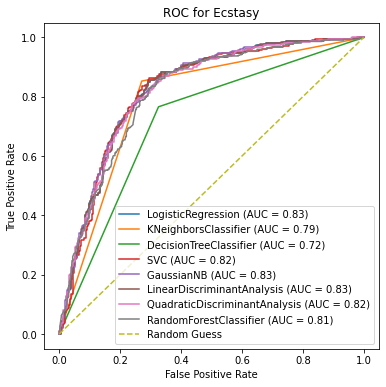

=======================================================AdaBoost=======================================================
Accuracy: 73.98 %
Precision score: 70.04 %
Recall/Sensibilité/sensitivity score: 83.30 %
F1 score: 76.09 %
=======================================================Bagging=======================================================
Accuracy: 78.41 %
Precision score: 75.71 %
Recall/Sensibilité/sensitivity score: 83.30 %
F1 score: 79.32 %
=======================================================Stacking Classifier=======================================================
Accuracy: 79.84 %
Precision score: 78.71 %
Recall/Sensibilité/sensitivity score: 81.51 %
F1 score: 80.09 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         75.80          74.15            82.41         78.06
KNN                         79.07          75.69            85.30         80.21
Decision Tree               71.98          69.92            76.61         73.11
SVM                         77.63          73.43            86.19         79.30
Naive Bayes                 76.63          72.04            86.64         78.67
LDA                         77.52          74.12            84.19         78.83
QDA                         76.19          71.99            85.30         78.08
Random Forest               75.53          70.14            88.42         78.23

In [475]:
split_train_evaluation_plot(X_rs_Ecstasy, y_rs_Ecstasy, verbose=False, plot_cm=False, title="ROC for Ecstasy")

# Heroin

In [476]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Heroin + Personality_columns]
drug = df_drug['Heroin']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Heroin:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Heroin = pd.concat([attributes, drug], axis=1)
df_Heroin.head()

==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Country    Nscore    Oscore    Cscore        SS  Heroin
ID                                                        
0       UK  0.313500 -0.585137 -0.006281 -1.222226       0
1       UK -0.679764  1.441683 -0.142775 -0.220519       0
2       UK -0.468308 -0.850217 -1.016902  0.420129       0
3       UK -0.149189 -0.018822  0.586885 -1.222226       0
4       UK  0.736994 -0.453034  1.310098 -0.220519       0

## One-Hot codage

In [477]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Heroin.iloc[:,0:1]
nominal_features = df_Heroin.iloc[:, 1:len(Demo_columns_Heroin)]

X = np.concatenate((Age, nominal_features, df_Heroin.iloc[:,len(Demo_columns_Heroin):-1]), axis=1)
y_Heroin = df_Heroin.iloc[:, -1]

# Ordinal encode age
# ordinal_encoder = OrdinalEncoder()
# ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, :len(Demo_columns_Heroin)])

X_Heroin = np.concatenate(
    (
    # ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,:len(Demo_columns_Heroin)]),
    X[:,len(Demo_columns_Heroin):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

# print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour les attributs nominaux:  [array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## Resampling





In [478]:
pip install imbalanced-learn

In [479]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Heroin, y_rs_Heroin = sampler.fit_sample(X_Heroin, y_Heroin)
print('Random undersampling {}'.format(Counter(y_rs_Heroin)))

Random undersampling Counter({0: 1767, 1: 1767})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## PCA - Dimension Reduction

In [480]:
from sklearn.decomposition import PCA

cls_Heroin = PCA(n_components=4)
pca_Heroin = cls_Heroin.fit_transform(X_rs_Heroin)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Heroin.explained_variance_ratio_, sum(cls_Heroin.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.43770774 0.27812506 0.14119161 0.09273748] - total: 0.9497618896354515


In [481]:
plot_pca(cls_Heroin, pca_Heroin, y_rs_Heroin, type="2D")

In [482]:
plot_pca(cls_Heroin, pca_Heroin, y_rs_Heroin, type="3D")

## Split & training & Evaluation & Plot

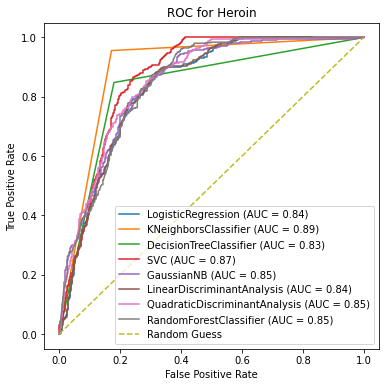

=======================================================AdaBoost=======================================================
Accuracy: 77.98 %
Precision score: 75.45 %
Recall/Sensibilité/sensitivity score: 80.92 %
F1 score: 78.09 %
=======================================================Bagging=======================================================
Accuracy: 88.26 %
Precision score: 83.15 %
Recall/Sensibilité/sensitivity score: 95.05 %
F1 score: 88.71 %
=======================================================Stacking Classifier=======================================================
Accuracy: 89.37 %
Precision score: 84.53 %
Recall/Sensibilité/sensitivity score: 95.58 %
F1 score: 89.72 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         77.89          73.22            83.57         78.05
KNN                         89.03          84.01            95.58         89.42
Decision Tree               83.38          81.63            84.81         83.19
SVM                         79.18          72.40            92.23         81.12
Naive Bayes                 77.29          74.24            81.45         77.67
LDA                         77.21          72.94            84.28         78.20
QDA                         77.55          73.82            83.22         78.24
Random Forest               76.95          73.09            83.04         77.75

In [483]:
split_train_evaluation_plot(pca_Heroin, y_rs_Heroin, verbose=False, plot_cm=False, title="ROC for Heroin")

# Ketamine

In [484]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Ketamine + Personality_columns]
drug = df_drug['Ketamine']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Ketamine:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Ketamine = pd.concat([attributes, drug], axis=1)
df_Ketamine.head()

==================Bien transformé pour [Age]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age    Nscore    Oscore    Cscore        SS  Ketamine
ID                                                         
0   35-44  0.313500 -0.585137 -0.006281 -1.222226         0
1   25-34 -0.679764  1.441683 -0.142775 -0.220519         0
2   35-44 -0.468308 -0.850217 -1.016902  0.420129         0
3   18-24 -0.149189 -0.018822  0.586885 -1.222226         0
4   35-44  0.736994 -0.453034  1.310098 -0.220519         0

## One-Hot codage

In [485]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Ketamine.iloc[:,0:1]
nominal_features = df_Ketamine.iloc[:, 1:len(Demo_columns_Ketamine)]

X = np.concatenate((Age, nominal_features, df_Ketamine.iloc[:,len(Demo_columns_Ketamine):-1]), axis=1)
y_Ketamine = df_Ketamine.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
# onehot_encoder = OneHotEncoder(sparse=False)
# onehot_encoder.fit(X[:, 1:len(Demo_columns_Ketamine)])

X_Ketamine = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    # onehot_encoder.transform(X[:,1:len(Demo_columns_Ketamine)]),
    X[:,len(Demo_columns_Ketamine):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
# print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]


## PCA - Dimension Reduction

In [486]:
from sklearn.decomposition import PCA

cls_Ketamine = PCA(n_components=4)
pca_Ketamine = cls_Ketamine.fit_transform(X_Ketamine)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Ketamine.explained_variance_ratio_, sum(cls_Ketamine.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.41025935 0.26768102 0.19121429 0.13084533] - total: 0.9999999999999999


In [487]:
plot_pca(cls_Ketamine, pca_Ketamine, y_Ketamine, type="2D")

In [488]:
plot_pca(cls_Ketamine, pca_Ketamine, y_Ketamine, type="3D")

## Resampling





In [489]:
pip install imbalanced-learn

In [490]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Ketamine, y_rs_Ketamine = sampler.fit_sample(pca_Ketamine, y_Ketamine)
print('Random undersampling {}'.format(Counter(y_rs_Ketamine)))

Random undersampling Counter({0: 1677, 1: 1677})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

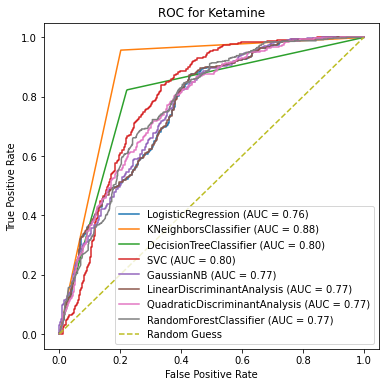

=======================================================AdaBoost=======================================================
Accuracy: 70.91 %
Precision score: 66.36 %
Recall/Sensibilité/sensitivity score: 81.41 %
F1 score: 73.12 %
=======================================================Bagging=======================================================
Accuracy: 84.37 %
Precision score: 80.57 %
Recall/Sensibilité/sensitivity score: 89.41 %
F1 score: 84.76 %
=======================================================Stacking Classifier=======================================================
Accuracy: 87.53 %
Precision score: 82.05 %
Recall/Sensibilité/sensitivity score: 95.17 %
F1 score: 88.12 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         69.01          65.66            76.77         70.78
KNN                         87.53          81.75            95.72         88.18
Decision Tree               79.95          77.82            82.16         79.93
SVM                         74.07          67.90            88.48         76.84
Naive Bayes                 70.28          65.08            83.83         73.27
LDA                         70.73          66.21            81.23         72.95
QDA                         70.37          64.54            86.62         73.97
Random Forest               70.73          65.29            84.94         73.83

In [491]:
split_train_evaluation_plot(X_rs_Ketamine, y_rs_Ketamine, verbose=False, plot_cm=False, title="ROC for Ketamine")

# Legalh

In [492]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Legalh + Personality_columns]
drug = df_drug['Legalh']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Legalh:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Legalh = pd.concat([attributes, drug], axis=1)
df_Legalh.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Gender]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age  Gender             Education  ...    Cscore        SS  Legalh
ID                                       ...                            
0   35-44  Female  Professional diploma  ... -0.006281 -1.222226       0
1   25-34    Male      Doctorate degree  ... -0.142775 -0.220519       0
2   35-44    Male  Professional diploma  ... -1.016902  0.420129       0
3   18-24  Female        Masters degree  ...  0.586885 -1.222226       0
4   35-44  Female      Doctorate degree  ...  1.310098 -0.220519       0

[5 rows x 9 columns]

## One-Hot codage

In [493]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Legalh.iloc[:,0:1]
nominal_features = df_Legalh.iloc[:, 1:len(Demo_columns_Legalh)]

X = np.concatenate((Age, nominal_features, df_Legalh.iloc[:,len(Demo_columns_Legalh):-1]), axis=1)
y_Legalh = df_Legalh.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Legalh)])

X_Legalh = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Legalh)]),
    X[:,len(Demo_columns_Legalh):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Female', 'Male'], dtype=object), array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [494]:
from sklearn.decomposition import PCA

cls_Legalh = PCA(n_components=4)
pca_Legalh = cls_Legalh.fit_transform(X_Legalh)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Legalh.explained_variance_ratio_, sum(cls_Legalh.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.31235456 0.19042839 0.14029224 0.10541734] - total: 0.7484925308078564


In [495]:
plot_pca(cls_Legalh, pca_Legalh, y_Legalh, type="2D")

In [496]:
plot_pca(cls_Legalh, pca_Legalh, y_Legalh, type="3D")

## Resampling





In [497]:
pip install imbalanced-learn

In [498]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Legalh, y_rs_Legalh = sampler.fit_sample(pca_Legalh, y_Legalh)
print('Random undersampling {}'.format(Counter(y_rs_Legalh)))

Random undersampling Counter({0: 1321, 1: 1321})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

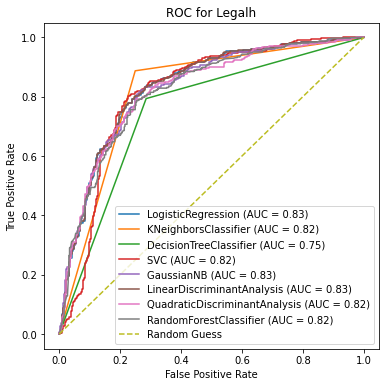

=======================================================AdaBoost=======================================================
Accuracy: 75.00 %
Precision score: 72.97 %
Recall/Sensibilité/sensitivity score: 77.75 %
F1 score: 75.28 %
=======================================================Bagging=======================================================
Accuracy: 79.93 %
Precision score: 76.36 %
Recall/Sensibilité/sensitivity score: 85.48 %
F1 score: 80.66 %
=======================================================Stacking Classifier=======================================================
Accuracy: 81.54 %
Precision score: 79.56 %
Recall/Sensibilité/sensitivity score: 83.84 %
F1 score: 81.64 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         77.10          75.22            80.33         77.69
KNN                         81.77          77.35            88.76         82.66
Decision Tree               75.34          72.75            79.39         75.92
SVM                         77.41          73.66            83.84         78.42
Naive Bayes                 76.26          72.45            83.14         77.43
LDA                         77.18          74.36            81.50         77.77
QDA                         76.15          72.58            82.44         77.19
Random Forest               75.92          73.33            79.86         76.46

In [499]:
split_train_evaluation_plot(X_rs_Legalh, y_rs_Legalh, verbose=False, plot_cm=False, title="ROC for Legalh")

# LSD

In [500]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_LSD + Personality_columns]
drug = df_drug['LSD']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_LSD:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_LSD = pd.concat([attributes, drug], axis=1)
df_LSD.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age Country    Nscore    Oscore    Cscore        SS  LSD
ID                                                            
0   35-44      UK  0.313500 -0.585137 -0.006281 -1.222226    0
1   25-34      UK -0.679764  1.441683 -0.142775 -0.220519    0
2   35-44      UK -0.468308 -0.850217 -1.016902  0.420129    0
3   18-24      UK -0.149189 -0.018822  0.586885 -1.222226    0
4   35-44      UK  0.736994 -0.453034  1.310098 -0.220519    0

## One-Hot codage

In [501]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_LSD.iloc[:,0:1]
nominal_features = df_LSD.iloc[:, 1:len(Demo_columns_LSD)]

X = np.concatenate((Age, nominal_features, df_LSD.iloc[:,len(Demo_columns_LSD):-1]), axis=1)
y_LSD = df_LSD.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_LSD)])

X_LSD = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_LSD)]),
    X[:,len(Demo_columns_LSD):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [502]:
from sklearn.decomposition import PCA

cls_LSD = PCA(n_components=4)
pca_LSD = cls_LSD.fit_transform(X_LSD)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_LSD.explained_variance_ratio_, sum(cls_LSD.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.37906414 0.23738151 0.17262194 0.11606396] - total: 0.905131547820393


In [503]:
plot_pca(cls_LSD, pca_LSD, y_LSD, type="2D")

In [504]:
plot_pca(cls_LSD, pca_LSD, y_LSD, type="3D")

## Resampling





In [505]:
pip install imbalanced-learn

In [506]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_LSD, y_rs_LSD = sampler.fit_sample(pca_LSD, y_LSD)
print('Random undersampling {}'.format(Counter(y_rs_LSD)))

Random undersampling Counter({0: 1505, 1: 1505})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

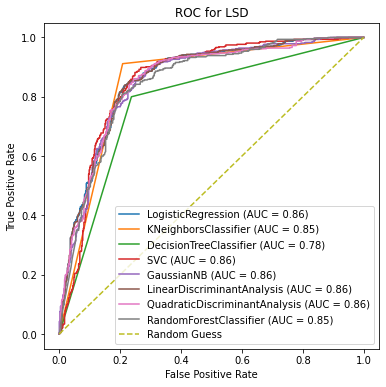

=======================================================AdaBoost=======================================================
Accuracy: 79.28 %
Precision score: 76.42 %
Recall/Sensibilité/sensitivity score: 81.89 %
F1 score: 79.07 %
=======================================================Bagging=======================================================
Accuracy: 83.50 %
Precision score: 80.55 %
Recall/Sensibilité/sensitivity score: 86.32 %
F1 score: 83.33 %
=======================================================Stacking Classifier=======================================================
Accuracy: 84.31 %
Precision score: 81.09 %
Recall/Sensibilité/sensitivity score: 87.58 %
F1 score: 84.21 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         80.07          76.66            85.05         80.64
KNN                         84.91          80.04            91.16         85.24
Decision Tree               78.07          75.55            80.00         77.71
SVM                         81.29          76.32            88.21         81.84
Naive Bayes                 79.07          73.30            88.42         80.15
LDA                         79.28          73.72            88.00         80.23
QDA                         79.38          72.73            90.95         80.82
Random Forest               77.67          72.39            86.11         78.65

In [507]:
split_train_evaluation_plot(X_rs_LSD, y_rs_LSD, verbose=False, plot_cm=False, title="ROC for LSD")

# Meth

In [508]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Meth + Personality_columns]
drug = df_drug['Meth']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Meth:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Meth = pd.concat([attributes, drug], axis=1)
df_Meth.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age             Education Country  ...    Cscore        SS  Meth
ID                                       ...                          
0   35-44  Professional diploma      UK  ... -0.006281 -1.222226     0
1   25-34      Doctorate degree      UK  ... -0.142775 -0.220519     1
2   35-44  Professional diploma      UK  ... -1.016902  0.420129     0
3   18-24        Masters degree      UK  ...  0.586885 -1.222226     0
4   35-44      Doctorate degree      UK  ...  1.310098 -0.220519     0

[5 rows x 8 columns]

## One-Hot codage

In [509]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Meth.iloc[:,0:1]
nominal_features = df_Meth.iloc[:, 1:len(Demo_columns_Meth)]

X = np.concatenate((Age, nominal_features, df_Meth.iloc[:,len(Demo_columns_Meth):-1]), axis=1)
y_Meth = df_Meth.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Meth)])

X_Meth = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Meth)]),
    X[:,len(Demo_columns_Meth):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [510]:
from sklearn.decomposition import PCA

cls_Meth = PCA(n_components=4)
pca_Meth = cls_Meth.fit_transform(X_Meth)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Meth.explained_variance_ratio_, sum(cls_Meth.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.33549732 0.20607488 0.14965979 0.1017776 ] - total: 0.7930095918768336


In [511]:
plot_pca(cls_Meth, pca_Meth, y_Meth, type="2D")

In [512]:
plot_pca(cls_Meth, pca_Meth, y_Meth, type="3D")

## Resampling





In [513]:
pip install imbalanced-learn

In [514]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Meth, y_rs_Meth = sampler.fit_sample(pca_Meth, y_Meth)
print('Random undersampling {}'.format(Counter(y_rs_Meth)))

Random undersampling Counter({0: 1565, 1: 1565})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

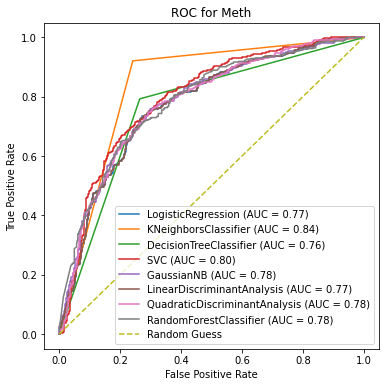

=======================================================AdaBoost=======================================================
Accuracy: 70.76 %
Precision score: 70.46 %
Recall/Sensibilité/sensitivity score: 69.63 %
F1 score: 70.04 %
=======================================================Bagging=======================================================
Accuracy: 81.51 %
Precision score: 78.32 %
Recall/Sensibilité/sensitivity score: 86.19 %
F1 score: 82.07 %
=======================================================Stacking Classifier=======================================================
Accuracy: 83.93 %
Precision score: 78.75 %
Recall/Sensibilité/sensitivity score: 92.11 %
F1 score: 84.91 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         72.27          70.61            75.35         72.90
KNN                         83.83          78.62            92.11         84.83
Decision Tree               76.38          74.31            79.29         76.72
SVM                         72.70          70.05            77.51         73.60
Naive Bayes                 71.83          68.88            77.71         73.03
LDA                         71.73          69.37            75.94         72.50
QDA                         72.02          68.99            78.11         73.27
Random Forest               71.83          71.09            71.79         71.44

In [515]:
split_train_evaluation_plot(X_rs_Meth, y_rs_Meth, verbose=False, plot_cm=False, title="ROC for Meth")

# Mushrooms

In [516]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Mushrooms + Personality_columns]
drug = df_drug['Mushrooms']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Mushrooms:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Mushrooms = pd.concat([attributes, drug], axis=1)
df_Mushrooms.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Gender]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age  Gender Country    Nscore    Oscore    Cscore        SS  Mushrooms
ID                                                                          
0   35-44  Female      UK  0.313500 -0.585137 -0.006281 -1.222226          0
1   25-34    Male      UK -0.679764  1.441683 -0.142775 -0.220519          0
2   35-44    Male      UK -0.468308 -0.850217 -1.016902  0.420129          0
3   18-24  Female      UK -0.149189 -0.018822  0.586885 -1.222226          0
4   35-44  Female      UK  0.736994 -0.453034  1.310098 -0.220519          0

## One-Hot codage

In [517]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Mushrooms.iloc[:,0:1]
nominal_features = df_Mushrooms.iloc[:, 1:len(Demo_columns_Mushrooms)]

X = np.concatenate((Age, nominal_features, df_Mushrooms.iloc[:,len(Demo_columns_Mushrooms):-1]), axis=1)
y_Mushrooms = df_Mushrooms.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Mushrooms)])

X_Mushrooms = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Mushrooms)]),
    X[:,len(Demo_columns_Mushrooms):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Female', 'Male'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## PCA - Dimension Reduction

In [518]:
from sklearn.decomposition import PCA

cls_Mushrooms = PCA(n_components=4)
pca_Mushrooms = cls_Mushrooms.fit_transform(X_Mushrooms)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Mushrooms.explained_variance_ratio_, sum(cls_Mushrooms.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.34855919 0.21680054 0.15983851 0.11824798] - total: 0.8434462191014932


In [519]:
plot_pca(cls_Mushrooms, pca_Mushrooms, y_Mushrooms, type="2D")

In [520]:
plot_pca(cls_Mushrooms, pca_Mushrooms, y_Mushrooms, type="3D")

## Resampling





In [521]:
pip install imbalanced-learn

In [522]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Mushrooms, y_rs_Mushrooms = sampler.fit_sample(pca_Mushrooms, y_Mushrooms)
print('Random undersampling {}'.format(Counter(y_rs_Mushrooms)))

Random undersampling Counter({0: 1451, 1: 1451})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## Split & training & Evaluation & Plot

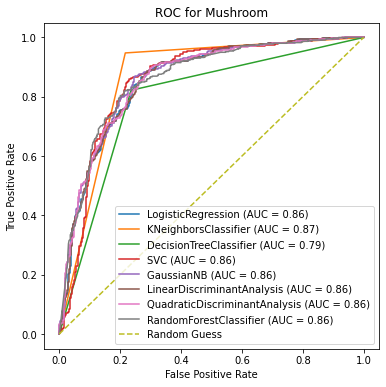

=======================================================AdaBoost=======================================================
Accuracy: 78.50 %
Precision score: 74.71 %
Recall/Sensibilité/sensitivity score: 83.48 %
F1 score: 78.85 %
=======================================================Bagging=======================================================
Accuracy: 84.34 %
Precision score: 79.47 %
Recall/Sensibilité/sensitivity score: 90.87 %
F1 score: 84.79 %
=======================================================Stacking Classifier=======================================================
Accuracy: 85.91 %
Precision score: 81.19 %
Recall/Sensibilité/sensitivity score: 91.96 %
F1 score: 86.24 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         79.15          75.49            84.35         79.67
KNN                         86.22          80.15            94.78         86.85
Decision Tree               79.12          76.32            81.96         79.04
SVM                         79.54          74.26            87.83         80.48
Naive Bayes                 78.91          73.04            88.91         80.20
LDA                         79.33          73.99            87.83         80.32
QDA                         79.33          73.39            89.35         80.59
Random Forest               77.77          72.41            86.74         78.93

In [523]:
split_train_evaluation_plot(X_rs_Mushrooms, y_rs_Mushrooms, verbose=False, plot_cm=False, title="ROC for Mushroom")

# Nicotine

In [524]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_Nicotine + Personality_columns]
drug = df_drug['Nicotine']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_Nicotine:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_Nicotine = pd.concat([attributes, drug], axis=1)
df_Nicotine.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Gender]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age  Gender             Education  ...    Cscore        SS  Nicotine
ID                                       ...                              
0   35-44  Female  Professional diploma  ... -0.006281 -1.222226         0
1   25-34    Male      Doctorate degree  ... -0.142775 -0.220519         1
2   35-44    Male  Professional diploma  ... -1.016902  0.420129         0
3   18-24  Female        Masters degree  ...  0.586885 -1.222226         0
4   35-44  Female      Doctorate degree  ...  1.310098 -0.220519         0

[5 rows x 9 columns]

## One-Hot codage

In [525]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_Nicotine.iloc[:,0:1]
nominal_features = df_Nicotine.iloc[:, 1:len(Demo_columns_Nicotine)]

X = np.concatenate((Age, nominal_features, df_Nicotine.iloc[:,len(Demo_columns_Nicotine):-1]), axis=1)
y_Nicotine = df_Nicotine.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_Nicotine)])

X_Nicotine = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_Nicotine)]),
    X[:,len(Demo_columns_Nicotine):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Female', 'Male'], dtype=object), array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## Resampling





In [526]:
pip install imbalanced-learn

In [527]:
# ClusterCentroids for Nicotine
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_Nicotine, y_rs_Nicotine = sampler.fit_sample(X_Nicotine, y_Nicotine)
print('Random undersampling {}'.format(Counter(y_rs_Nicotine)))

Random undersampling Counter({0: 1060, 1: 1060})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## PCA - Dimension Reduction

In [528]:
from sklearn.decomposition import PCA

cls_Nicotine = PCA(n_components=4)
pca_Nicotine = cls_Nicotine.fit_transform(X_rs_Nicotine)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_Nicotine.explained_variance_ratio_, sum(cls_Nicotine.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.31752103 0.18865812 0.14118069 0.10539183] - total: 0.7527516656591481


In [529]:
plot_pca(cls_Nicotine, pca_Nicotine, y_rs_Nicotine, type="2D")

In [530]:
plot_pca(cls_Nicotine, pca_Nicotine, y_rs_Nicotine, type="3D")

## Split & training & Evaluation & Plot

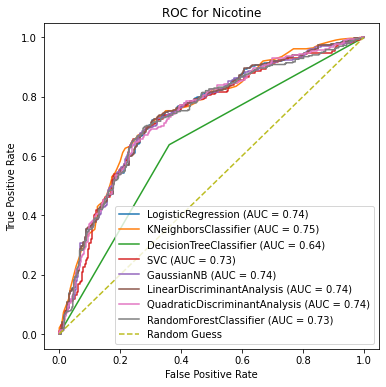

=======================================================AdaBoost=======================================================
Accuracy: 67.29 %
Precision score: 64.96 %
Recall/Sensibilité/sensitivity score: 70.88 %
F1 score: 67.79 %
=======================================================Bagging=======================================================
Accuracy: 70.86 %
Precision score: 69.10 %
Recall/Sensibilité/sensitivity score: 72.35 %
F1 score: 70.69 %
=======================================================Stacking Classifier=======================================================
Accuracy: 70.00 %
Precision score: 67.76 %
Recall/Sensibilité/sensitivity score: 72.94 %
F1 score: 70.25 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         69.48          68.93            71.76         70.32
KNN                         70.00          67.38            74.12         70.59
Decision Tree               63.86          62.54            63.82         63.17
SVM                         69.43          66.94            73.24         69.94
Naive Bayes                 70.00          67.76            72.94         70.25
LDA                         70.43          68.63            72.06         70.30
QDA                         69.29          68.12            69.12         68.61
Random Forest               70.14          68.45            71.47         69.93

In [531]:
split_train_evaluation_plot(pca_Nicotine, y_rs_Nicotine, verbose=False, plot_cm=False, title="ROC for Nicotine")

# VSA

In [532]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug[Demo_columns_VSA + Personality_columns]
drug = df_drug['VSA']

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']


for item in Demo_columns_VSA:
  # Transformation - Age
  if item == 'Age':
    valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
  if item == 'Gender':
    valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
  if item == 'Education':
    valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
  if item == 'Country':
    valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
  if item == 'Ethnicity':
    valueToMeaning(attributes, 'Ethnicity', ethnicity)

# Combinaison des deux dataframes
df_VSA = pd.concat([attributes, drug], axis=1)
df_VSA.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Country]=========


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age Country    Nscore    Oscore    Cscore        SS  VSA
ID                                                            
0   35-44      UK  0.313500 -0.585137 -0.006281 -1.222226    0
1   25-34      UK -0.679764  1.441683 -0.142775 -0.220519    0
2   35-44      UK -0.468308 -0.850217 -1.016902  0.420129    0
3   18-24      UK -0.149189 -0.018822  0.586885 -1.222226    0
4   35-44      UK  0.736994 -0.453034  1.310098 -0.220519    0

## One-Hot codage

In [533]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

Age = df_VSA.iloc[:,0:1]
nominal_features = df_VSA.iloc[:, 1:len(Demo_columns_VSA)]

X = np.concatenate((Age, nominal_features, df_VSA.iloc[:,len(Demo_columns_VSA):-1]), axis=1)
y_VSA = df_VSA.iloc[:, -1]

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:len(Demo_columns_VSA)])

X_VSA = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:len(Demo_columns_VSA)]),
    X[:,len(Demo_columns_VSA):-1]
    ), axis=1)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


## Resampling





In [534]:
# Resampling
import imblearn
from imblearn.over_sampling import SMOTE

# ClusterCentroids for Amphet
sampler = SMOTE(sampling_strategy='auto', random_state=42)
X_rs_VSA, y_rs_VSA = sampler.fit_sample(X_VSA, y_VSA)
print('Random undersampling {}'.format(Counter(y_rs_VSA)))

Random undersampling Counter({0: 1790, 1: 1790})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## PCA - Dimension Reduction

In [535]:
from sklearn.decomposition import PCA

cls_VSA = PCA(n_components=4)
pca_VSA = cls_VSA.fit_transform(X_rs_VSA)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls_VSA.explained_variance_ratio_, sum(cls_VSA.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.3833218  0.2757723  0.14773621 0.10422757] - total: 0.9110578808790442


In [536]:
plot_pca(cls_VSA, pca_VSA, y_rs_VSA, type="2D")

In [537]:
plot_pca(cls_VSA, pca_VSA, y_rs_VSA, type="3D")

## Split & training & Evaluation & Plot

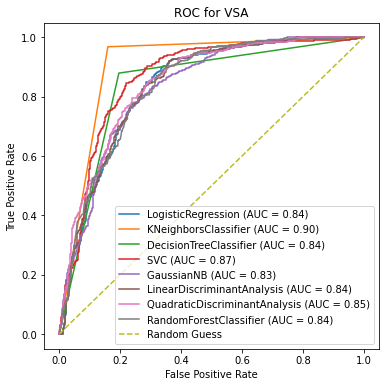

=======================================================AdaBoost=======================================================
Accuracy: 78.09 %
Precision score: 74.05 %
Recall/Sensibilité/sensitivity score: 84.49 %
F1 score: 78.93 %
=======================================================Bagging=======================================================
Accuracy: 89.34 %
Precision score: 84.46 %
Recall/Sensibilité/sensitivity score: 95.64 %
F1 score: 89.71 %
=======================================================Stacking Classifier=======================================================
Accuracy: 90.02 %
Precision score: 85.19 %
Recall/Sensibilité/sensitivity score: 96.17 %
F1 score: 90.34 %


Accuracy (%)  Precision (%)  Sensitivity (%)  F1 Socre (%)
Logistic Regression         76.45          72.79            86.24         78.95
KNN                         90.27          85.15            96.86         90.63
Decision Tree               84.09          80.93            87.98         84.31
SVM                         80.12          75.57            87.28         81.00
Naive Bayes                 75.72          71.20            83.97         77.06
LDA                         76.82          70.55            89.72         78.99
QDA                         76.82          71.37            87.28         78.53
Random Forest               76.73          71.21            87.46         78.50

In [538]:
split_train_evaluation_plot(pca_VSA, y_rs_VSA, verbose=False, plot_cm=False, title="ROC for VSA")